<a href="https://colab.research.google.com/github/evalcas/climate-variables-senamhi-augusto-weberbauer-cajamarca-1994-2024/blob/main/Dataset_Imputation_Senamhi30Year.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Montamos google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Librerias requeridas
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

In [ ]:
# prompt: conectate a google drive para solicitar acceso y luego al archivo: /content/drive/My Drive/ColabNotebooks/Bi-LSTM/DATA30YEAR/DataSenamhi30Year.xlsx y almacenalo en df_procesado

df_procesado = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Research/Bi-LSTM/DATA30YEAR/DataSenamhi30Year.xlsx')


In [ ]:
# prompt: usando df_procesado crea un indice fecha utilizando la columna ProcessDate
# verifica que no haya fechas faltantes, si los hay visualizalos
# luego muestra los datos faltantes del df_procesado

# Establecer 'ProcessDate' como índice
df_procesado = df_procesado.set_index('ProcessDate')

# Verificar fechas faltantes
fechas_minima = df_procesado.index.min()
fechas_maxima = df_procesado.index.max()

rango_fechas = pd.date_range(start=fechas_minima, end=fechas_maxima)
fechas_faltantes = rango_fechas.difference(df_procesado.index)

if not fechas_faltantes.empty:
  print("Fechas faltantes:")
  print(fechas_faltantes)
else:
  print("No hay fechas faltantes en el DataFrame.")

# Mostrar datos faltantes en el DataFrame
print("\nDatos faltantes en df_procesado:")
print(df_procesado.isna().sum())

No hay fechas faltantes en el DataFrame.

Datos faltantes en df_procesado:
Year                      0
Month                     0
Day                       0
PrecipitacionDiaria     137
TemperaturaMedia        396
HumedadRelativa         508
PresionAtmosferica      327
VelocidadViento        1288
HorasSol                163
dtype: int64


In [ ]:
# Creando un nuevo dataframe pero con las columnas en ingles
df_process = df_procesado.rename(columns={
    'PrecipitacionDiaria': 'DailyPrecipitation',
    'TemperaturaMedia': 'AverageTemperature',
    'HumedadRelativa': 'RelativeHumidity',
    'PresionAtmosferica': 'AtmosphericPressure',
    'VelocidadViento': 'WindSpeed',
    'HorasSol': 'SunshineHours'
})


KeyError: "None of ['ProcessDate'] are in the columns"

In [ ]:
# prompt: muestrame informacion de los valores faltantes relacionados a su proporcion y distribucion expresado en porcentaje de la variables del dataset df_procesado

# Calcular el porcentaje de valores faltantes por columna
missing_percentage = df_procesado.isnull().sum() * 100 / len(df_procesado)

# Crear un DataFrame para mostrar la información
missing_info = pd.DataFrame({
    'Variable': missing_percentage.index,
    'Valores Faltantes': df_procesado.isnull().sum().values,
    'Porcentaje de Valores Faltantes': missing_percentage.values
})

# Ordenar por porcentaje de valores faltantes (de mayor a menor)
missing_info = missing_info.sort_values(by='Porcentaje de Valores Faltantes', ascending=False)

# Mostrar la información
missing_info


Variable  Valores Faltantes  Porcentaje de Valores Faltantes
7      VelocidadViento               1288                        11.375077
5      HumedadRelativa                508                         4.486444
4     TemperaturaMedia                396                         3.497306
6   PresionAtmosferica                327                         2.887927
8             HorasSol                163                         1.439548
3  PrecipitacionDiaria                137                         1.209927
0                 Year                  0                         0.000000
1                Month                  0                         0.000000
2                  Day                  0                         0.000000

In [ ]:
df_procesado.info()

#df_imputacion_estacional = df_procesado.copy() # para aplicar el algoritmo de  imputacion estacional
#df_imputacion_machine_learning = df_procesado.copy() # para aplicar el algoritmo de imputacion con algoritmos de machine learning

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11323 entries, 1994-01-01 to 2024-12-31
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 11323 non-null  int64  
 1   Month                11323 non-null  int64  
 2   Day                  11323 non-null  int64  
 3   PrecipitacionDiaria  11186 non-null  float64
 4   TemperaturaMedia     10927 non-null  float64
 5   HumedadRelativa      10815 non-null  float64
 6   PresionAtmosferica   10996 non-null  float64
 7   VelocidadViento      10035 non-null  float64
 8   HorasSol             11160 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 884.6 KB


# Imputacion de datos
Metodos utilizados:
Se entiende que se tienen datos meteorológicos de 30 años, desde 1994 hasta 2024, y que se necesita imputar los valores faltantes para evitar alterar los datos lo menos posible.  Es una situación común en datos de series temporales, especialmente en datos del mundo real como los meteorológicos, donde pueden existir interrupciones o periodos sin registro.

Para abordar el problema de imputación de datos faltantes en la serie temporal meteorológica, y buscando minimizar la alteración de los datos, existen varios métodos, comenzando por el que se considera más adecuado para el caso y siguiendo con alternativas.
1. Promedio Histórico (Promedio Estacional)
- Dado que los datos son de series temporales meteorológicas, que suelen tener fuertes patrones estacionales y anuales, la imputación por promedio histórico o promedio estacional es una de las mejores opciones y la que se considera más adecuada para minimizar la alteración de los datos y mantener la integridad de los patrones temporales.
- ¿En qué consiste la imputación por promedio histórico?
  La idea principal es que para cada valor faltante en una fecha específica (por ejemplo, el 20 de marzo de 2020), se reemplace por el promedio de los valores correspondientes a la misma fecha (20 de marzo) pero de otros años disponibles en el conjunto de datos. De esta manera se aprovecha la estacionalidad y los patrones históricos de los datos meteorológicos.

- Pasos para implementar la imputación por promedio histórico:
  1. Identifica los datos faltantes: Primero, debes identificar las fechas exactas donde tienes valores faltantes en las columnas de datos meteorológicos (PrecipitacionDiaria, TemperaturaMedia, HumedadRelativa, PresionAtmosferica, VelocidadViento, HorasSol).
  2. Agrupa los datos por mes y día:  Para cada columna que deseas imputar, agrupa el DataFrame por Month y Day.
  3. Calcula el promedio histórico para cada día del año: Para cada grupo (combinación de mes y día), calcula el promedio de los valores de la columna correspondiente a lo largo de todos los años disponibles excepto el año en el que estás imputando.  Es importante excluir el año actual en el que faltan datos para no influir el promedio con los propios valores faltantes si hubiera otros periodos de datos faltantes en ese mismo año.
  4. Imputa los valores faltantes:  Para cada fecha con un valor faltante, utiliza el promedio histórico calculado en el paso 3 para el mes y día correspondientes.
- Ventajas de la imputación por promedio histórico:
  * Preserva la estacionalidad: Captura los patrones cíclicos anuales de los datos meteorológicos.
  * Simple de implementar: Es relativamente fácil de entender y codificar.
  * Mínima alteración de patrones: Al usar datos históricos reales para imputar, se reduce la introducción de datos "artificiales" que podrían distorsionar las tendencias generales.
  * Intuitiva para datos meteorológicos: Se basa en la premisa lógica de que el clima en una fecha específica tiende a ser similar año tras año.
- Limitaciones:
  * No considera eventos atípicos: Si el año con datos faltantes fue excepcionalmente diferente a los años históricos (por ejemplo, un año de sequía extrema o un año muy lluvioso), el promedio histórico podría no ser tan representativo.
  * Puede suavizar variaciones interanuales: Al promediar, puede reducir la variabilidad natural que existe de un año a otro para una misma fecha.


In [ ]:
import pandas as pd
from sklearn.impute import KNNImputer
import numpy as np
from scipy.interpolate import interp1d
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats import skew, kurtosis, ks_2samp, entropy
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Funciones de Imputación
# Promedio historico: Usa el índice de tiempo para interpolar valores faltantes.
def promedio_historico(df, columnas_a_imputar):
    """
    Imputa valores faltantes en un DataFrame con índice 'ProcessDate' y columnas 'Year', 'Month', 'Day'
    usando el promedio histórico (estacional).

    Args:
        df (pd.DataFrame): DataFrame con índice 'ProcessDate' y columnas 'Year', 'Month', 'Day'.
        columnas_a_imputar (list): Lista de nombres de columnas a imputar.

    Returns:
        pd.DataFrame: DataFrame con los valores faltantes imputados.
    """

    print("--- Iniciando la imputación por promedio histórico ---")

    # Cantidad inicial de datos faltantes por variable
    cantidad_faltantes_inicial = df[columnas_a_imputar].isnull().sum()
    print("\nCantidad inicial de datos faltantes por variable:")
    print(cantidad_faltantes_inicial)

    df_imputado = df.copy()
    datos_imputados_totales = {columna: 0 for columna in columnas_a_imputar}
    start_time = time.time()
    for columna in columnas_a_imputar:
        print(f"\n--- Imputando columna: {columna} ---")

        meses = df['Month'].unique()
        for month in sorted(meses):
            dias_validos = df.loc[df['Month'] == month, 'Day'].unique()

            for day in sorted(dias_validos):
                # Calcular el promedio histórico sin incluir valores NaN
                datos_dia_historico = df.loc[(df['Month'] == month) & (df['Day'] == day), columna].dropna()
                promedio_historico = datos_dia_historico.mean() if not datos_dia_historico.empty else None

                if promedio_historico is not None:
                    # Imputar valores faltantes en la copia
                    mask_faltantes = (df_imputado['Month'] == month) & (df_imputado['Day'] == day) & (df_imputado[columna].isnull())
                    cantidad_imputados = mask_faltantes.sum()
                    df_imputado.loc[mask_faltantes, columna] = promedio_historico
                    datos_imputados_totales[columna] += cantidad_imputados

    end_time = time.time()
    print(f"Interpolación Temporal: {end_time - start_time} segundos")
    # Cantidad final de datos faltantes
    cantidad_faltantes_final = df_imputado[columnas_a_imputar].isnull().sum()

    print("\nCantidad final de datos faltantes por variable:")
    print(cantidad_faltantes_final)

    print("\nCantidad total de datos imputados por variable:")
    for columna, cantidad in datos_imputados_totales.items():
        print(f"  {columna}: {cantidad} imputados")

    print("\n--- Proceso de imputación completado ---")
    return df_imputado

# Interpolación Temporal: Usa el índice de tiempo para interpolar valores faltantes.
def interpolacion_temporal(df):
    start_time = time.time()
    df_interpolated = df.interpolate(method='time')
    end_time = time.time()
    print(f"Interpolación Temporal: {end_time - start_time} segundos")
    return df_interpolated

# Interpolación Lineal: Interpola valores faltantes usando una línea recta entre puntos conocidos.
def interpolacion_lineal(df):
    start_time = time.time()
    df_interpolated = df.interpolate(method='linear')
    end_time = time.time()
    print(f"Interpolación Lineal: {end_time - start_time} segundos")
    return df_interpolated

# Descomposición Temporal: Usa descomposición temporal para imputar valores faltantes.
def descomposicion_temporal(df):
    start_time = time.time()
    df_imputed = df.copy()
    for col in df.columns:
        # Descomposición temporal
        result = seasonal_decompose(df[col].dropna(), model='additive', period=365, extrapolate_trend='freq')
        df_imputed[col] = result.trend + result.seasonal + result.resid
    end_time = time.time()
    print(f"Descomposición Temporal: {end_time - start_time} segundos")
    return df_imputed

# KNN Imputation: Usa K-vecinos más cercanos para imputar valores faltantes.
def knn_imputation(df, n_neighbors=5):
    start_time = time.time()
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    df_imputed = df.copy()
    for col in df.columns:
        missing = df[col].isnull()
        if missing.any():
            X = df.index[~missing].values.reshape(-1, 1)
            y = df[col][~missing].values
            knn.fit(X, y)
            df_imputed.loc[missing, col] = knn.predict(df.index[missing].values.reshape(-1, 1))
    end_time = time.time()
    print(f"KNN Imputation: {end_time - start_time} segundos")
    return df_imputed

# MICE (Multiple Imputation by Chained Equations): Usa regresión iterativa para imputar valores faltantes.
def mice_imputation(df):
    start_time = time.time()
    mice_imputer = IterativeImputer(max_iter=10, random_state=42)
    df_imputed = pd.DataFrame(mice_imputer.fit_transform(df), columns=df.columns, index=df.index)
    end_time = time.time()
    print(f"MICE Imputation: {end_time - start_time} segundos")
    return df_imputed

# Media Móvil Estacional: Usa la media móvil para imputar valores faltantes.
def media_movil_estacional(df, window=3):
    start_time = time.time()
    df_imputed = df.rolling(window=window, min_periods=1).mean()
    end_time = time.time()
    print(f"Media Móvil Estacional: {end_time - start_time} segundos")
    return df_imputed


# --- Aplicar las funciones de imputación ---
# Supongamos que tu DataFrame de entrada se llama 'df_procesado' y tiene 'ProcessDate' como índice

# Excluir columnas no estacionales

columnas_a_imputar = ['PrecipitacionDiaria', 'TemperaturaMedia', 'HumedadRelativa', 'PresionAtmosferica', 'VelocidadViento', 'HorasSol']
df_procesado_estacional = df_procesado[columnas_a_imputar]

# Asegurar que las fechas están ordenadas correctamente
df_procesado = df_procesado.sort_values(by=["Year", "Month", "Day"])


print("DataFrame original antes de la imputación (primeras filas):")
print(df_procesado.head())

df_imputacion_estacional = promedio_historico(df_procesado.copy(), columnas_a_imputar)
df_imputacion_interpolacion_temporal = interpolacion_temporal(df_procesado_estacional.copy())
df_imputacion_interpolacion_lineal = interpolacion_lineal(df_procesado_estacional.copy())
df_imputacion_descomposicion_temporal = descomposicion_temporal(df_procesado_estacional.copy())
df_imputacion_knn = knn_imputation(df_procesado_estacional.copy())
df_imputacion_mice = mice_imputation(df_procesado_estacional.copy())
df_imputacion_media_movil = media_movil_estacional(df_procesado_estacional.copy())



DataFrame original antes de la imputación (primeras filas):
             Year  Month  Day  PrecipitacionDiaria  TemperaturaMedia  \
ProcessDate                                                            
1994-01-01   1994      1    1                  0.2              14.9   
1994-01-02   1994      1    2                  7.7              15.1   
1994-01-03   1994      1    3                  0.0              14.0   
1994-01-04   1994      1    4                  0.0              15.3   
1994-01-05   1994      1    5                  5.1              15.1   

             HumedadRelativa  PresionAtmosferica  VelocidadViento  HorasSol  
ProcessDate                                                                  
1994-01-01              76.2               740.1              1.3       6.8  
1994-01-02              77.8               739.9              1.3       1.6  
1994-01-03              73.1               739.5              1.7       6.8  
1994-01-04              66.9               74

# EVALUACION DE LA IMPUTACION

## 1. EVALUACION ESTADISTICA Y VISUAL

Comparacion de Rangos y distribucion

* Rangos Históricos: Comprueba que los valores imputados se encuentren dentro de rangos razonables comparados con datos históricos.
* Estadísticas Descriptivas: Revisa la media, mediana, varianza, etc., antes y después de la imputación para detectar posibles sesgos.
* Histogramas y Densidades: Grafica histogramas de la serie original e imputada para verificar que la forma de la distribución se mantenga.


Rangos Historicos

Se calcula los valores mínimos y máximos históricos de cada variable y verificar que los valores imputados se mantengan dentro de ese rango.

Si hay valores fuera del rango histórico, podrías revisar si la imputación es adecuada.

In [ ]:
# Rangos historicos
import pandas as pd

def evaluar_imputacion(df_original, df_imputado, columnas):
    """
    Evalúa la imputación verificando cuántos valores imputados están fuera del rango histórico.

    :param df_original: DataFrame con los datos originales.
    :param df_imputado: DataFrame con los datos imputados.
    :param columnas: Lista de nombres de las columnas a evaluar.
    :return: Ninguno. Imprime el número de valores fuera del rango histórico para cada columna.
    """
    for columna in columnas:
        # Calcular el rango histórico de la columna en los datos originales
        min_historico = df_original[columna].min()
        max_historico = df_original[columna].max()

        # Identificar valores imputados fuera del rango histórico
        valores_fuera_rango = df_imputado[
            (df_imputado[columna] < min_historico) |
            (df_imputado[columna] > max_historico)
        ]

        # Contar el número de valores fuera de rango
        num_fuera_rango = len(valores_fuera_rango)

        print(f"\nValores imputados fuera del rango histórico en '{columna}': {num_fuera_rango}")


# Evaluar imputaciones en df_interpolacion
print("1 Evaluación de df_imputacion_estacional:")
evaluar_imputacion(df_procesado, df_imputacion_estacional, columnas_a_imputar)
print("2 Evaluación de df_imputacion_interpolacion_temporal:")
evaluar_imputacion(df_procesado, df_imputacion_interpolacion_temporal, columnas_a_imputar)
print("3 Evaluación de df_imputacion_interpolacion_lineal:")
evaluar_imputacion(df_procesado, df_imputacion_interpolacion_lineal, columnas_a_imputar)
print("4 Evaluación de df_imputacion_descomposicion_temporal:")
evaluar_imputacion(df_procesado, df_imputacion_descomposicion_temporal, columnas_a_imputar)
print("5 Evaluación de df_imputacion_knn:")
evaluar_imputacion(df_procesado, df_imputacion_knn, columnas_a_imputar)
print("6 Evaluación de df_imputacion_mice:")
evaluar_imputacion(df_procesado, df_imputacion_mice, columnas_a_imputar)
print("7 Evaluación de df_imputacion_media_movil:")
evaluar_imputacion(df_procesado, df_imputacion_media_movil, columnas_a_imputar)



1 Evaluación de df_imputacion_estacional:

Valores imputados fuera del rango histórico en 'PrecipitacionDiaria': 0

Valores imputados fuera del rango histórico en 'TemperaturaMedia': 0

Valores imputados fuera del rango histórico en 'HumedadRelativa': 0

Valores imputados fuera del rango histórico en 'PresionAtmosferica': 0

Valores imputados fuera del rango histórico en 'VelocidadViento': 0

Valores imputados fuera del rango histórico en 'HorasSol': 0
2 Evaluación de df_imputacion_interpolacion_temporal:

Valores imputados fuera del rango histórico en 'PrecipitacionDiaria': 0

Valores imputados fuera del rango histórico en 'TemperaturaMedia': 0

Valores imputados fuera del rango histórico en 'HumedadRelativa': 0

Valores imputados fuera del rango histórico en 'PresionAtmosferica': 0

Valores imputados fuera del rango histórico en 'VelocidadViento': 0

Valores imputados fuera del rango histórico en 'HorasSol': 0
3 Evaluación de df_imputacion_interpolacion_lineal:

Valores imputados fue

In [ ]:
# prompt: usando los dataframes imputados:
# df_imputacion_estacional
# df_imputacion_interpolacion_temporal
# df_imputacion_interpolacion_lineal
# df_imputacion_descomposicion_temporal
# df_imputacion_knn
# df_imputacion_mice
# df_imputacion_media_movil
# y el dataframe original df_procesado sin imputar, genera una tabla de rangos historicos con porcentajes de valores fueran de rango

def generar_tabla_rangos(df_original, df_imputados, columnas):
    """
    Genera una tabla de rangos históricos con porcentajes de valores fuera de rango para cada método de imputación.

    Args:
        df_original: DataFrame original sin imputar.
        df_imputados: Diccionario con los DataFrames imputados, donde la clave es el nombre del método.
        columnas: Lista de columnas a evaluar.

    Returns:
        pandas.DataFrame: Tabla resumen con los resultados.
    """

    resultados = []
    for nombre_metodo, df_imputado in df_imputados.items():
        for columna in columnas:
            min_historico = df_original[columna].min()
            max_historico = df_original[columna].max()

            fuera_rango = df_imputado[
                (df_imputado[columna] < min_historico) |
                (df_imputado[columna] > max_historico)
            ]
            porcentaje_fuera_rango = (len(fuera_rango) / len(df_imputado)) * 100 if len(df_imputado) > 0 else 0

            resultados.append({
                'Método de Imputación': nombre_metodo,
                'Variable': columna,
                'Mínimo Histórico': min_historico,
                'Máximo Histórico': max_historico,
                'Valores Fuera de Rango': len(fuera_rango),
                'Porcentaje Fuera de Rango': porcentaje_fuera_rango
            })
    return pd.DataFrame(resultados)


# Crear un diccionario con los DataFrames imputados
dataframes_imputados = {
    'Estacional': df_imputacion_estacional,
    'Interpolación Temporal': df_imputacion_interpolacion_temporal,
    'Interpolación Lineal': df_imputacion_interpolacion_lineal,
    'Descomposición Temporal': df_imputacion_descomposicion_temporal,
    'KNN': df_imputacion_knn,
    'MICE': df_imputacion_mice,
    'Media Móvil': df_imputacion_media_movil
}

# Generar y mostrar la tabla de rangos
tabla_rangos = generar_tabla_rangos(df_procesado, dataframes_imputados, columnas_a_imputar)
tabla_rangos


Método de Imputación             Variable  Mínimo Histórico  \
0                Estacional  PrecipitacionDiaria               0.0   
1                Estacional     TemperaturaMedia              10.6   
2                Estacional      HumedadRelativa              29.9   
3                Estacional   PresionAtmosferica             736.6   
4                Estacional      VelocidadViento               0.0   
5                Estacional             HorasSol               0.0   
6    Interpolación Temporal  PrecipitacionDiaria               0.0   
7    Interpolación Temporal     TemperaturaMedia              10.6   
8    Interpolación Temporal      HumedadRelativa              29.9   
9    Interpolación Temporal   PresionAtmosferica             736.6   
10   Interpolación Temporal      VelocidadViento               0.0   
11   Interpolación Temporal             HorasSol               0.0   
12     Interpolación Lineal  PrecipitacionDiaria               0.0   
13     Interpolación Lineal     TemperaturaMedia              10.6   
14     Interpolación Lineal      HumedadRelativa              29.9   
15     Interpolación Lineal   PresionAtmosferica             736.6   
16     Interpolación Lineal      VelocidadViento               0.0   
17     Interpolación Lineal             HorasSol               0.0   
18  Descomposición Temporal  PrecipitacionDiaria               0.0   
19  Descomposición Temporal     TemperaturaMedia              10.6   
20  Descomposición Temporal      HumedadRelativa              29.9   
21  Descomposición Temporal   PresionAtmosferica             736.6   
22  Descomposición Temporal      VelocidadViento               0.0   
23  Descomposición Temporal             HorasSol               0.0   
24                      KNN  PrecipitacionDiaria               0.0   
25                      KNN     TemperaturaMedia              10.6   
26                      KNN      HumedadRelativa              29.9   
27                      KNN   PresionAtmosferica             736.6   
28                      KNN      VelocidadViento               0.0   
29                      KNN             HorasSol               0.0   
30                     MICE  PrecipitacionDiaria               0.0   
31                     MICE     TemperaturaMedia              10.6   
32                     MICE      HumedadRelativa              29.9   
33                     MICE   PresionAtmosferica             736.6   
34                     MICE      VelocidadViento               0.0   
35                     MICE             HorasSol               0.0   
36              Media Móvil  PrecipitacionDiaria               0.0   
37              Media Móvil     TemperaturaMedia              10.6   
38              Media Móvil      HumedadRelativa              29.9   
39              Media Móvil   PresionAtmosferica             736.6   
40              Media Móvil      VelocidadViento               0.0   
41              Media Móvil             HorasSol               0.0   

    Máximo Histórico  Valores Fuera de Rango  Porcentaje Fuera de Rango  
0               51.8                       0                   0.000000  
1               18.5                       0                   0.000000  
2               93.9                       0                   0.000000  
3              749.7                       0                   0.000000  
4                8.3                       0                   0.000000  
5               12.3                       0                   0.000000  
6               51.8                       0                   0.000000  
7               18.5                       0                   0.000000  
8               93.9                       0                   0.000000  
9              749.7                       0                   0.000000  
10               8.3                       0                   0.000000  
11              12.3                       0                   0.000000  
12              51.8              

In [ ]:
# prompt: # prompt: Ahora quiero analizar las imputaciones realizadas usando estadisticas descriptivas, mostrando las diferencias relativas en la media por cada metodo y variable. La tabla a generar debe seguir la estructura: Metodo de interpolacion, Temperatura, Precipitacion, Humedad, Presion, Viento, Horas Sol, y en cada fila mostrar el metodo y por cada variable la diferencia relativa en % a cuatro digitos

def generar_tabla_diferencias_relativas(df_original, df_imputados, columnas):
    """
    Genera una tabla con las diferencias relativas en la media para cada método de imputación,
    formateada a cuatro decimales.

    Args:
        df_original: DataFrame original sin imputar.
        df_imputados: Diccionario con los DataFrames imputados, donde la clave es el nombre del método.
        columnas: Lista de columnas a evaluar.

    Returns:
        pandas.DataFrame: Tabla resumen con los resultados.
    """

    resultados = []
    for nombre_metodo, df_imputado in df_imputados.items():
        fila = {'Metodo de interpolacion': nombre_metodo}
        for columna in columnas:
            media_original = df_original[columna].mean()
            media_imputada = df_imputado[columna].mean()

            if media_original == 0:
                diferencia_relativa = 0  # Evitar división por cero
            else:
                diferencia_relativa = ((media_imputada - media_original) / media_original) * 100

            fila[columna] = round(diferencia_relativa, 4) # Formato a 4 decimales
        resultados.append(fila)
    return pd.DataFrame(resultados)

# Usar la función para generar la tabla
tabla_diferencias = generar_tabla_diferencias_relativas(df_procesado, dataframes_imputados, columnas_a_imputar)
tabla_diferencias


Metodo de interpolacion  PrecipitacionDiaria  TemperaturaMedia  \
0               Estacional               0.0656            0.0430   
1   Interpolación Temporal              -0.2949            0.0618   
2     Interpolación Lineal              -0.2949            0.0618   
3  Descomposición Temporal               0.0000            0.0000   
4                      KNN               0.3209            0.0977   
5                     MICE              -0.0195            0.0130   
6              Media Móvil              -0.0278            0.0458   

   HumedadRelativa  PresionAtmosferica  VelocidadViento  HorasSol  
0           0.0812             -0.0004          -0.0302   -0.0334  
1           0.1237             -0.0025          -2.9636   -0.3981  
2           0.1237             -0.0025          -2.9636   -0.3981  
3           0.0000              0.0000           0.0000    0.0000  
4           0.0950             -0.0020          -1.3175   -0.1742  
5           0.1677             -0.0003          -0.3551    0.0028  
6           0.0541              0.0001          -0.0451    0.0080

In [ ]:
# prompt: Ahora quiero analizar las imputaciones realizadas usando estadisticas descriptivas, mostrando las diferencias relativas en la desviacion estandar por cada metodo y variable. La tabla a generar debe seguir la estructura: Metodo de interpolacion, Temperatura, Precipitacion, Humedad, Presion, Viento, Horas Sol, y en cada fila mostrar el metodo y por cada variable la diferencia relativa en % a cinco digitos

def generar_tabla_diferencias_relativas_std(df_original, df_imputados, columnas):
    """
    Genera una tabla con las diferencias relativas en la desviación estándar para cada método de imputación,
    formateada a cinco decimales.

    Args:
        df_original: DataFrame original sin imputar.
        df_imputados: Diccionario con los DataFrames imputados, donde la clave es el nombre del método.
        columnas: Lista de columnas a evaluar.

    Returns:
        pandas.DataFrame: Tabla resumen con los resultados.
    """

    resultados = []
    for nombre_metodo, df_imputado in df_imputados.items():
        fila = {'Metodo de interpolacion': nombre_metodo}
        for columna in columnas:
            std_original = df_original[columna].std()
            std_imputada = df_imputado[columna].std()

            if std_original == 0:
                diferencia_relativa = 0  # Evitar división por cero
            else:
                diferencia_relativa = ((std_imputada - std_original) / std_original) * 100

            fila[columna] = round(diferencia_relativa, 4)  # Formato a 5 decimales
        resultados.append(fila)
    return pd.DataFrame(resultados)

# Usar la función para generar la tabla
tabla_diferencias_std = generar_tabla_diferencias_relativas_std(df_procesado, dataframes_imputados, columnas_a_imputar)
tabla_diferencias_std


Metodo de interpolacion  PrecipitacionDiaria  TemperaturaMedia  \
0               Estacional              -0.5194           -1.4670   
1   Interpolación Temporal              -0.5429           -0.8211   
2     Interpolación Lineal              -0.5429           -0.8211   
3  Descomposición Temporal              -0.0000            0.0000   
4                      KNN              -0.5485           -0.9465   
5                     MICE              -0.5990           -1.6706   
6              Media Móvil             -27.4476          -15.7344   

   HumedadRelativa  PresionAtmosferica  VelocidadViento  HorasSol  
0          -1.7823             -1.2950          -5.1155   -0.6298  
1          -0.6830              0.2657          -3.0138   -0.2316  
2          -0.6830              0.2657          -3.0138   -0.2316  
3           0.0000              0.0000           0.0000    0.0000  
4          -0.8709              0.6034          -5.1077   -0.5349  
5          -0.9803             -1.4132          -4.9735   -0.6371  
6          -9.6343             -3.7022         -19.2383  -22.4190

In [ ]:
# prompt: Ahora quiero analizar las imputaciones realizadas usando estadisticas descriptivas, mostrando las diferencias relativas en la asimetria por cada metodo y variable. La tabla a generar debe seguir la estructura: Metodo de interpolacion, Temperatura, Precipitacion, Humedad, Presion, Viento, Horas Sol, y en cada fila mostrar el metodo y por cada variable la diferencia relativa en % a cinco digitos

def generar_tabla_diferencias_relativas_asimetria(df_original, df_imputados, columnas):
    """
    Genera una tabla con las diferencias relativas en la asimetría para cada método de imputación,
    formateada a cinco decimales.

    Args:
        df_original: DataFrame original sin imputar.
        df_imputados: Diccionario con los DataFrames imputados, donde la clave es el nombre del método.
        columnas: Lista de columnas a evaluar.

    Returns:
        pandas.DataFrame: Tabla resumen con los resultados.
    """

    resultados = []
    for nombre_metodo, df_imputado in df_imputados.items():
        fila = {'Metodo de interpolacion': nombre_metodo}
        for columna in columnas:
            asimetria_original = skew(df_original[columna].dropna()) #Usar dropna para evitar errores con datos faltantes
            asimetria_imputada = skew(df_imputado[columna].dropna())

            if asimetria_original == 0:
                diferencia_relativa = 0  # Evitar división por cero
            else:
                diferencia_relativa = ((asimetria_imputada - asimetria_original) / asimetria_original) * 100

            fila[columna] = round(diferencia_relativa, 4)  # Formato a 5 decimales
        resultados.append(fila)
    return pd.DataFrame(resultados)

# Usar la función para generar la tabla
tabla_diferencias_asimetria = generar_tabla_diferencias_relativas_asimetria(df_procesado, dataframes_imputados, columnas_a_imputar)
tabla_diferencias_asimetria


Metodo de interpolacion  PrecipitacionDiaria  TemperaturaMedia  \
0               Estacional               0.3378          206.2538   
1   Interpolación Temporal               0.5445          130.3462   
2     Interpolación Lineal               0.5445          130.3462   
3  Descomposición Temporal               0.0000            0.0000   
4                      KNN               0.3103          289.1569   
5                     MICE               0.5933           62.3157   
6              Media Móvil             -33.3365         -439.6180   

   HumedadRelativa  PresionAtmosferica  VelocidadViento  HorasSol  
0           6.1197              1.7113           4.1547    3.8915  
1           9.8493             -2.0992          10.0868   37.0990  
2           9.8493             -2.0992          10.0868   37.0990  
3          -0.0000             -0.0000          -0.0000   -0.0000  
4           7.5858             -2.8100          10.8898   21.7485  
5          -0.9254              1.8988           4.9838    0.8691  
6          51.2586              9.7822           2.5060  542.3811

In [ ]:
# prompt: Ahora quiero analizar las imputaciones realizadas usando estadisticas descriptivas, mostrando las diferencias relativas en la curtosis por cada metodo y variable. La tabla a generar debe seguir la estructura: Metodo de interpolacion, Temperatura, Precipitacion, Humedad, Presion, Viento, Horas Sol, y en cada fila mostrar el metodo y por cada variable la diferencia relativa en % a cinco digitos

def generar_tabla_diferencias_relativas_curtosis(df_original, df_imputados, columnas):
    """
    Genera una tabla con las diferencias relativas en la curtosis para cada método de imputación,
    formateada a cinco decimales.

    Args:
        df_original: DataFrame original sin imputar.
        df_imputados: Diccionario con los DataFrames imputados, donde la clave es el nombre del método.
        columnas: Lista de columnas a evaluar.

    Returns:
        pandas.DataFrame: Tabla resumen con los resultados.
    """

    resultados = []
    for nombre_metodo, df_imputado in df_imputados.items():
        fila = {'Metodo de interpolacion': nombre_metodo}
        for columna in columnas:
            curtosis_original = kurtosis(df_original[columna].dropna())
            curtosis_imputada = kurtosis(df_imputado[columna].dropna())

            if curtosis_original == 0:
                diferencia_relativa = 0  # Evitar división por cero
            else:
                diferencia_relativa = ((curtosis_imputada - curtosis_original) / curtosis_original) * 100

            fila[columna] = round(diferencia_relativa, 5)  # Formato a 5 decimales
        resultados.append(fila)
    return pd.DataFrame(resultados)

# Usar la función para generar la tabla
tabla_diferencias_curtosis = generar_tabla_diferencias_relativas_curtosis(df_procesado, dataframes_imputados, columnas_a_imputar)
tabla_diferencias_curtosis


Metodo de interpolacion  PrecipitacionDiaria  TemperaturaMedia  \
0               Estacional              1.01978         -43.01268   
1   Interpolación Temporal              1.28271         -11.24158   
2     Interpolación Lineal              1.28271         -11.24158   
3  Descomposición Temporal              0.00000          -0.00000   
4                      KNN              1.04882         -17.46199   
5                     MICE              1.43791         -56.52970   
6              Media Móvil            -59.72095         -28.74660   

   HumedadRelativa  PresionAtmosferica  VelocidadViento  HorasSol  
0      -3306.97588             7.00613         18.52668  -2.48628  
1      -1369.78295            -4.76176         10.16286  -0.18916  
2      -1369.78295            -4.76176         10.16286  -0.18916  
3          0.00000            -0.00000          0.00000  -0.00000  
4      -1463.52770            -7.89797         22.31743  -2.10935  
5      -2937.47988             8.28770         18.32636  -2.74267  
6       -708.09258            15.29951         -1.43616 -41.93934

Evaluación de Cambios en las Estadísticas Descriptivas

  En este análisis, evaluamos el impacto de la imputación de datos estacionales en las variables ambientales. Se compararon las estadísticas antes y después de la imputación, calculando los cambios porcentuales en métricas clave como media, mediana, desviación estándar, IQR (rango intercuartil), coeficiente de variación, curtosis y asimetría.


Para facilitar la interpretación de los cambios, se utilizó un código de colores basado en la magnitud del cambio porcentual:

Color	Significado
- 🔴 Rojo	Incremento alto (>10%) en una métrica tras la imputación. Ejemplo: Aumento en la media debido a valores imputados más altos.
- 🔵 Azul	Reducción significativa (<-10%), indicando que la imputación ha disminuido la variabilidad. Ejemplo: Reducción en desviación estándar.
- 🟡 Amarillo	Cambio moderado (-10% a 10%), lo que indica una variación leve en la métrica analizada.
- ⚪ Blanco	Sin cambios o cambios insignificantes, lo que indica que la imputación no alteró la métrica de manera considerable.

In [ ]:
# Estadisticas descriptivas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
from tabulate import tabulate

# -------------------------------
# 1. Función para Filtrar Variables Ambientales
# -------------------------------
def filtrar_variables_ambientales(df):
    """Excluye las columnas Year, Month y Day para analizar solo las variables ambientales."""
    return df.drop(columns=["Year", "Month", "Day"], errors="ignore")

# -------------------------------
# 2. Función para Calcular Estadísticas Descriptivas
# -------------------------------
def calcular_estadisticas(df):
    """Calcula estadísticas descriptivas extendidas para cada variable numérica."""
    stats = df.describe().T
    stats["Mediana"] = df.median()
    #stats["Curtosis"] = df.apply(kurtosis)
    #stats["Asimetría"] = df.apply(skew)
    stats["IQR"] = stats["75%"] - stats["25%"]
    stats["Coef_Variacion"] = stats["std"] / stats["mean"]
    #return stats[["mean", "Mediana", "std", "min", "max", "IQR", "Coef_Variacion", "Curtosis", "Asimetría"]]
    return stats[["mean", "Mediana", "std", "min", "max", "IQR", "Coef_Variacion"]]
# -------------------------------
# 3. Función para Evaluar Cambios Estadísticos
# -------------------------------
def evaluar_cambios_estadisticos(df_original, df_imputado):
    """Compara estadísticas antes y después de la imputación en variables ambientales."""
    df_original = filtrar_variables_ambientales(df_original)
    df_imputado = filtrar_variables_ambientales(df_imputado)

    stats_antes = calcular_estadisticas(df_original)
    stats_despues = calcular_estadisticas(df_imputado)

    # Calcular diferencia porcentual
    cambios_pct = ((stats_despues - stats_antes) / stats_antes) * 100
    cambios_pct = cambios_pct.replace([np.inf, -np.inf], np.nan)

    # Unir resultados en un solo DataFrame
    df_resultado = stats_antes.join(stats_despues, rsuffix="_despues")
    df_resultado = df_resultado.join(cambios_pct, rsuffix="_cambio")

    return df_resultado.round(3), cambios_pct.round(2)

# -------------------------------
# 4. Función para Formatear Tabla con Colores ANSI
# -------------------------------
def color_valor(valor, cambio):
    """Devuelve un valor coloreado dependiendo del nivel de cambio porcentual."""
    if isinstance(valor, (int, float)):
        if cambio == 0 or np.isnan(cambio):
            return f"\033[97m{valor:.2f}%\033[0m"  # ⚪ Blanco (sin cambio)
        elif cambio > 10:
            return f"\033[91m{valor:.2f}%\033[0m"  # 🔴 Rojo (incremento alto)
        elif cambio < -10:
            return f"\033[94m{valor:.2f}%\033[0m"  # 🔵 Azul (reducción significativa)
        else:
            return f"\033[93m{valor:.2f}%\033[0m"  # 🟡 Amarillo (cambio moderado)
    return valor

def formatear_tabla(df, cambios, dataframe_name):
    """Aplica colores ANSI solo a los valores que han cambiado."""
    df_coloreado = df.copy()
    for col in cambios.columns:
        df_coloreado[col] = [color_valor(df.loc[idx, col], cambios.loc[idx, col]) for idx in df.index]

    print(f"\n📊 Comparación de Estadísticas Antes y Después de la Imputación (Variables Ambientales) para {dataframe_name}: \n")
    print(tabulate(df_coloreado, headers='keys', tablefmt='pretty'))

    # Leyenda de colores
    print("\n🔴 \033[91mIncremento alto (>10%)\033[0m | 🔵 \033[94mReducción significativa (<-10%)\033[0m | 🟡 \033[93mCambio moderado (-10% a 10%)\033[0m | ⚪ Sin cambio\033[0m")

# -------------------------------
# 5. Función para Graficar Cambios con Barras Apiladas
# -------------------------------
def graficar_cambios_barras(df_cambios):
    """Genera un gráfico de barras apiladas para mostrar cambios porcentuales en estadísticas descriptivas."""
    df_cambios = df_cambios.replace(0, np.nan)  # Ocultar valores sin cambio
    df_cambios.plot(kind='bar', figsize=(12, 6), colormap="RdYlBu_r", edgecolor='black')

    plt.axhline(0, color='black', linewidth=1)  # Línea de referencia en 0%
    plt.ylabel("Cambio porcentual (%)")
    plt.xlabel("Variables Ambientales")
    plt.title("Cambio Porcentual en las Estadísticas Descriptivas Tras la Imputación")
    plt.legend(title="Estadística", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

# -------------------------------
# 6. Cargar Datos y Ejecutar Análisis
# -------------------------------
# Comparacion df_procesado y el dataframe imputado
df_comparacion1, cambios_pct1 = evaluar_cambios_estadisticos(df_procesado, df_imputacion_estacional)
df_comparacion2, cambios_pct2 = evaluar_cambios_estadisticos(df_procesado, df_imputacion_interpolacion_temporal)
df_comparacion3, cambios_pct3 = evaluar_cambios_estadisticos(df_procesado, df_imputacion_interpolacion_lineal)
df_comparacion7, cambios_pct7 = evaluar_cambios_estadisticos(df_procesado, df_imputacion_descomposicion_temporal)
df_comparacion4, cambios_pct4 = evaluar_cambios_estadisticos(df_procesado, df_imputacion_knn)
df_comparacion5, cambios_pct5 = evaluar_cambios_estadisticos(df_procesado, df_imputacion_mice)
df_comparacion6, cambios_pct6 = evaluar_cambios_estadisticos(df_procesado, df_imputacion_media_movil)


#df_comparacion4, cambios_pct4 = evaluar_cambios_estadisticos(df_procesado, df_final)
# Mostrar Tabla con Comparaciones
formatear_tabla(df_comparacion1, cambios_pct1, "Imputacion Estacional")
formatear_tabla(df_comparacion2, cambios_pct2, "Imputacion por interpolacion temporal")
formatear_tabla(df_comparacion3, cambios_pct3, "Imputacion por descomposicion lineal")
formatear_tabla(df_comparacion4, cambios_pct4, "Imputacion por descomposicion temporal")
formatear_tabla(df_comparacion5, cambios_pct5, "Imputacion por KNN")
formatear_tabla(df_comparacion6, cambios_pct6, "Imputacion por MICE")
formatear_tabla(df_comparacion7, cambios_pct7, "Imputacion por media movil")


#formatear_tabla(df_comparacion4, cambios_pct4)

# Mostrar Gráfico de Barras Apiladas
# graficar_cambios_barras(cambios_pct)


📊 Comparación de Estadísticas Antes y Después de la Imputación (Variables Ambientales) para Imputacion Estacional: 

+---------------------+---------+---------+-------+---------+---------+--------+----------------+--------------+-----------------+-------------+-------------+-------------+-------------+------------------------+-------------+----------------+------------+------------+------------+------------+-----------------------+
|                     |  mean   | Mediana |  std  |   min   |   max   |  IQR   | Coef_Variacion | mean_despues | Mediana_despues | std_despues | min_despues | max_despues | IQR_despues | Coef_Variacion_despues | mean_cambio | Mediana_cambio | std_cambio | min_cambio | max_cambio | IQR_cambio | Coef_Variacion_cambio |
+---------------------+---------+---------+-------+---------+---------+--------+----------------+--------------+-----------------+-------------+-------------+-------------+-------------+------------------------+-------------+----------------+--

Histogramas y densidades

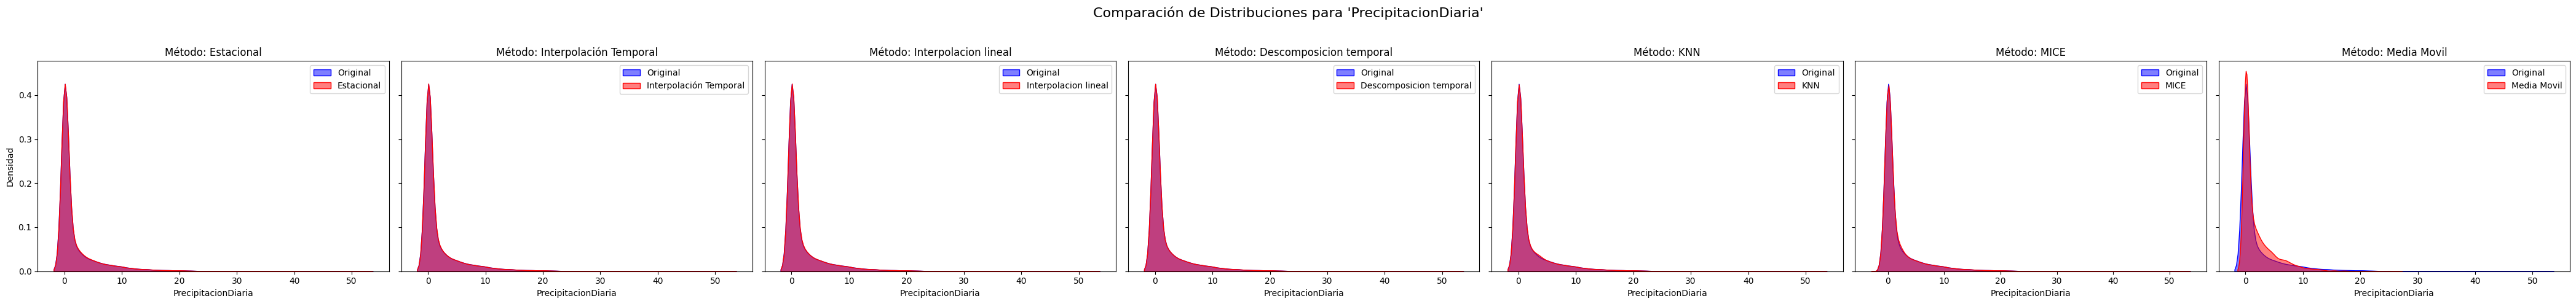

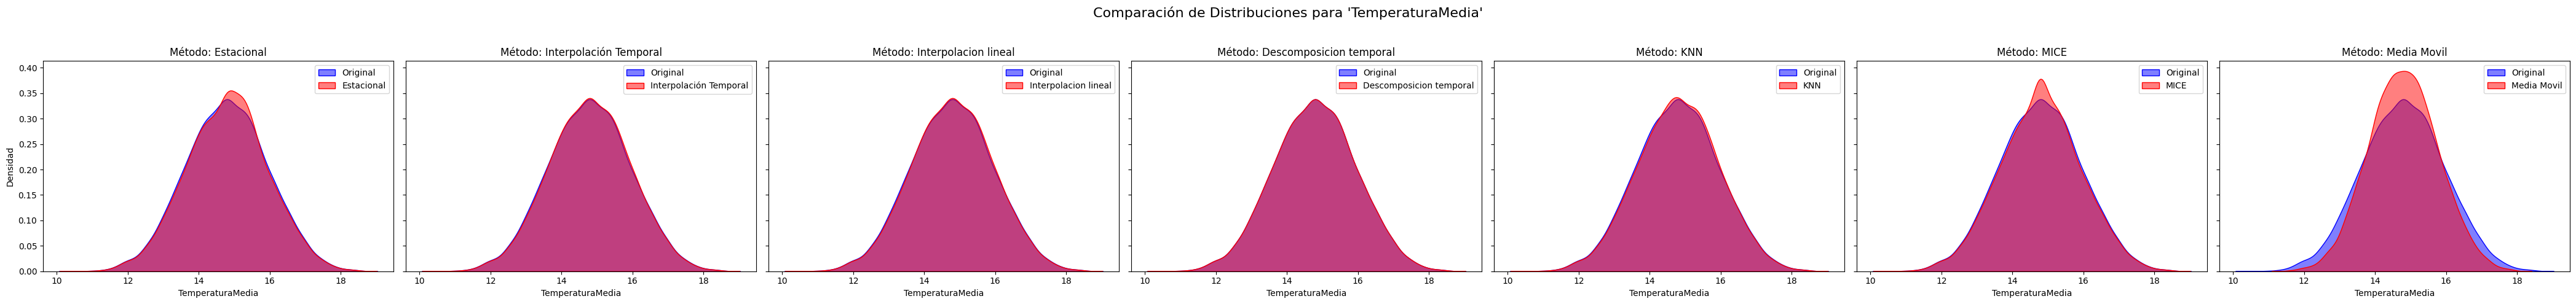

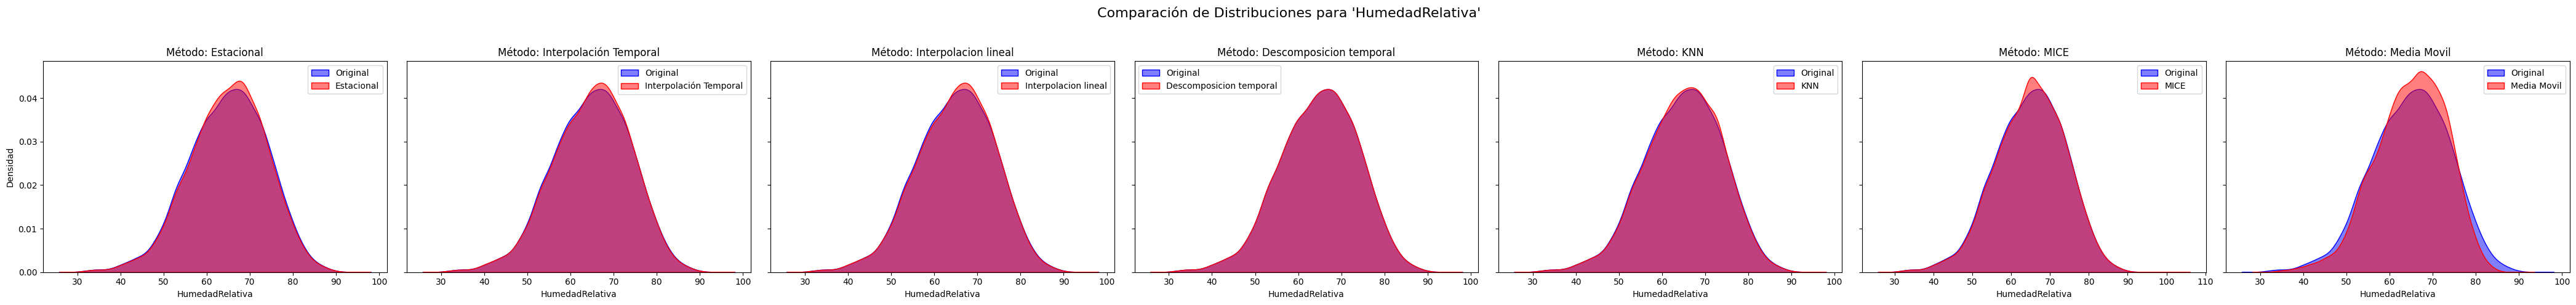

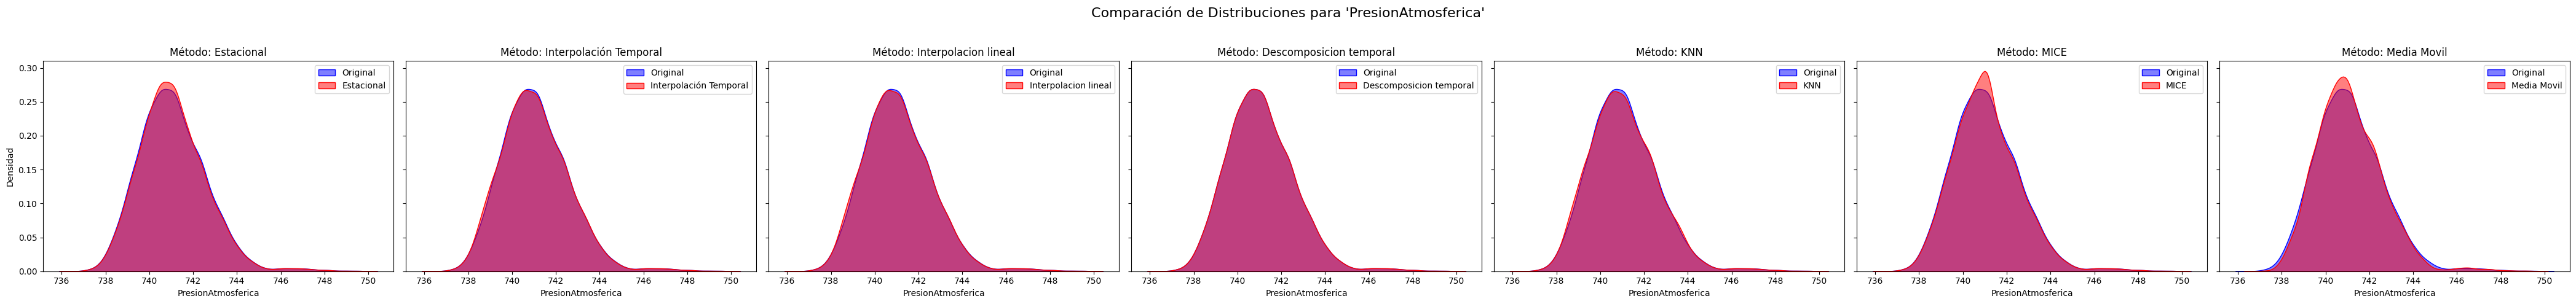

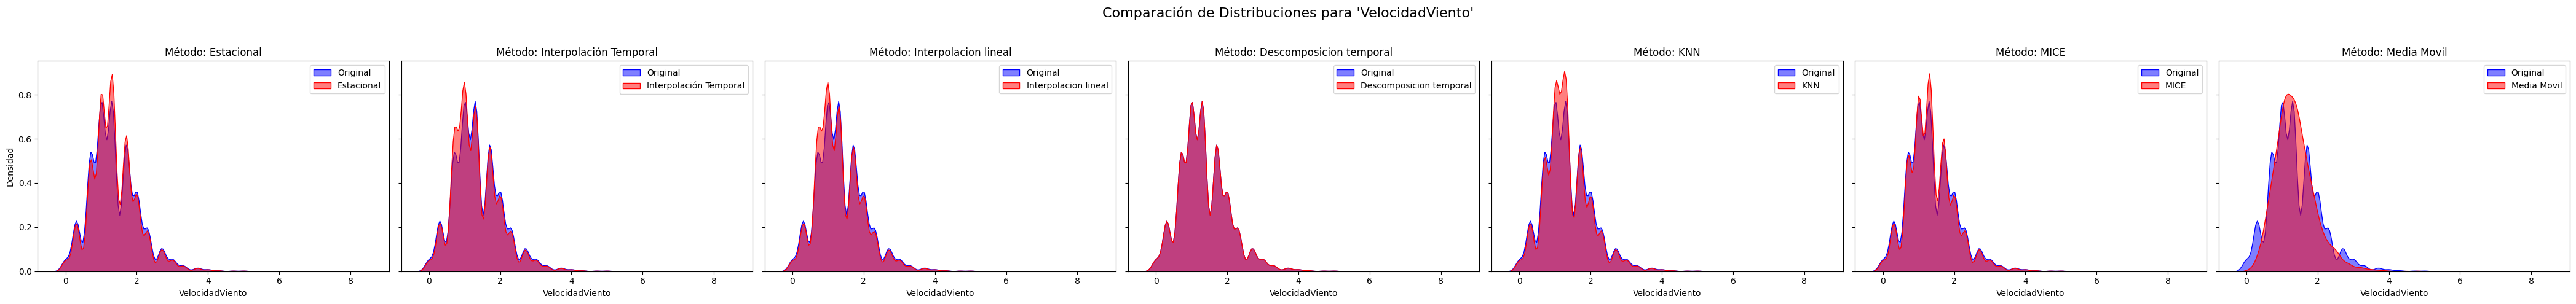

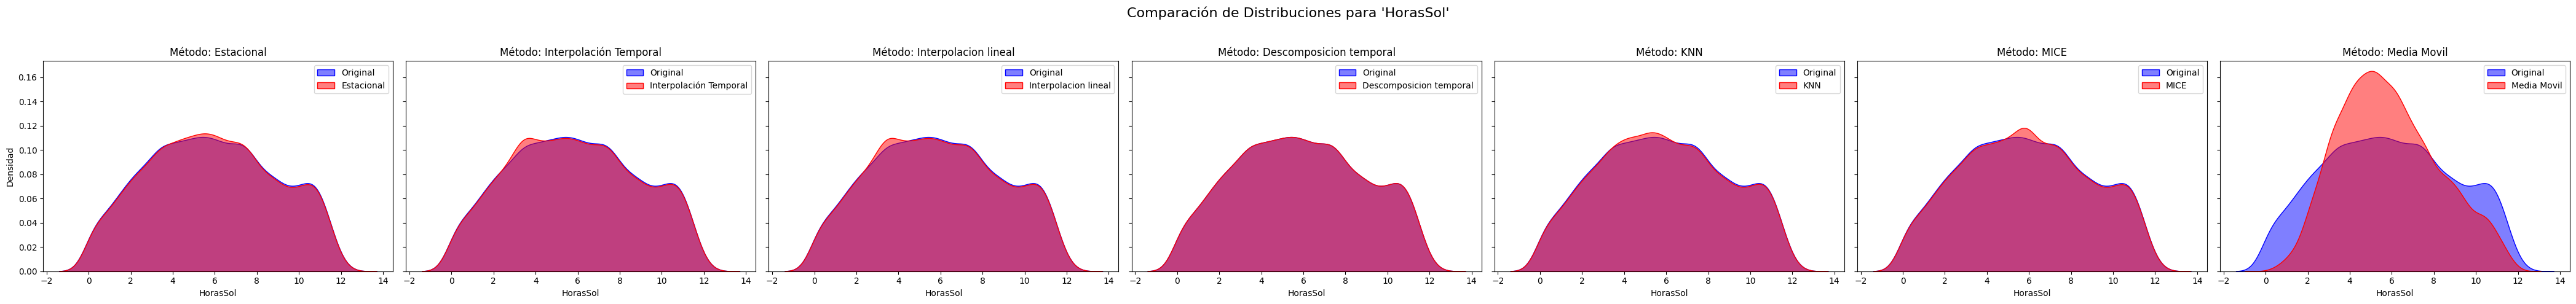

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def comparar_distribuciones_lado_a_lado(df_original, df_imputados, variable, etiquetas, titulo=None):
    """
    Grafica las distribuciones de una variable antes y después de la imputación,
    mostrando los gráficos de los distintos métodos de imputación lado a lado.

    :param df_original: DataFrame con los datos originales.
    :param df_imputados: Lista de DataFrames con los datos imputados.
    :param variable: Nombre de la variable a comparar.
    :param etiquetas: Lista de etiquetas para cada DataFrame imputado.
    :param titulo: Título opcional para el conjunto de gráficos.
    """
    num_metodos = len(df_imputados)
    fig, axes = plt.subplots(1, num_metodos, figsize=(6 * num_metodos, 5), sharey=True)

    if titulo:
        fig.suptitle(titulo, fontsize=16)

    for ax, df_imputado, etiqueta in zip(axes, df_imputados, etiquetas):
        sns.kdeplot(df_original[variable].dropna(), label="Original", fill=True, alpha=0.5, color="blue", ax=ax)
        sns.kdeplot(df_imputado[variable].dropna(), label=etiqueta, fill=True, alpha=0.5, color="red", ax=ax)
        ax.set_title(f"Método: {etiqueta}")
        ax.set_xlabel(variable)
        ax.set_ylabel("Densidad")
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Lista de columnas a evaluar
columnas_a_imputar = ['PrecipitacionDiaria', 'TemperaturaMedia', 'HumedadRelativa',
                      'PresionAtmosferica', 'VelocidadViento', 'HorasSol']

# Lista de DataFrames imputados y sus etiquetas correspondientes
dataframes_imputados = [df_imputacion_estacional, df_imputacion_interpolacion_temporal, df_imputacion_interpolacion_lineal, df_imputacion_descomposicion_temporal, df_imputacion_knn, df_imputacion_mice, df_imputacion_media_movil]
etiquetas_imputados = ["Estacional", "Interpolación Temporal", "Interpolacion lineal", "Descomposicion temporal", "KNN", "MICE","Media Movil"]


# Generar los gráficos de comparación para cada variable
for columna in columnas_a_imputar:
    comparar_distribuciones_lado_a_lado(df_procesado, dataframes_imputados, columna, etiquetas_imputados,
                                        titulo=f"Comparación de Distribuciones para '{columna}'")

Densidades

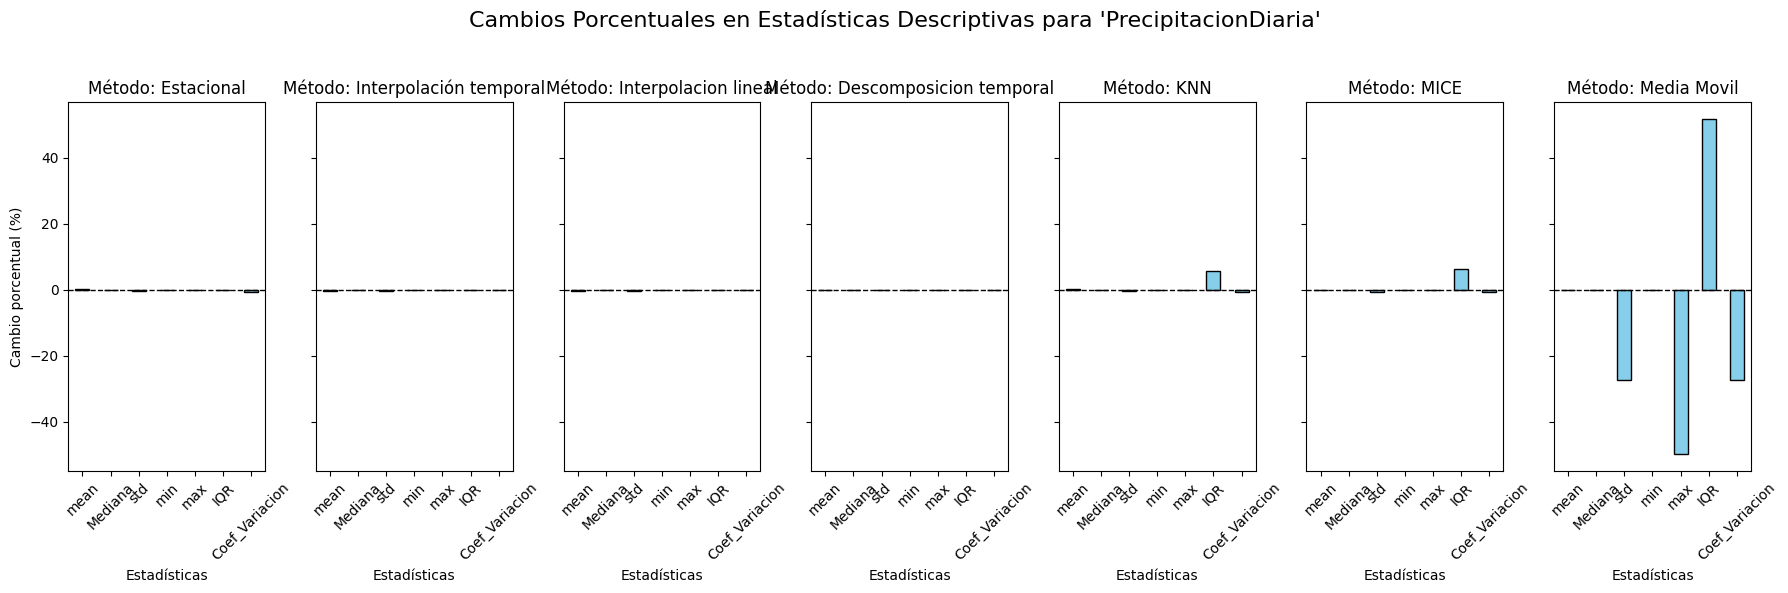

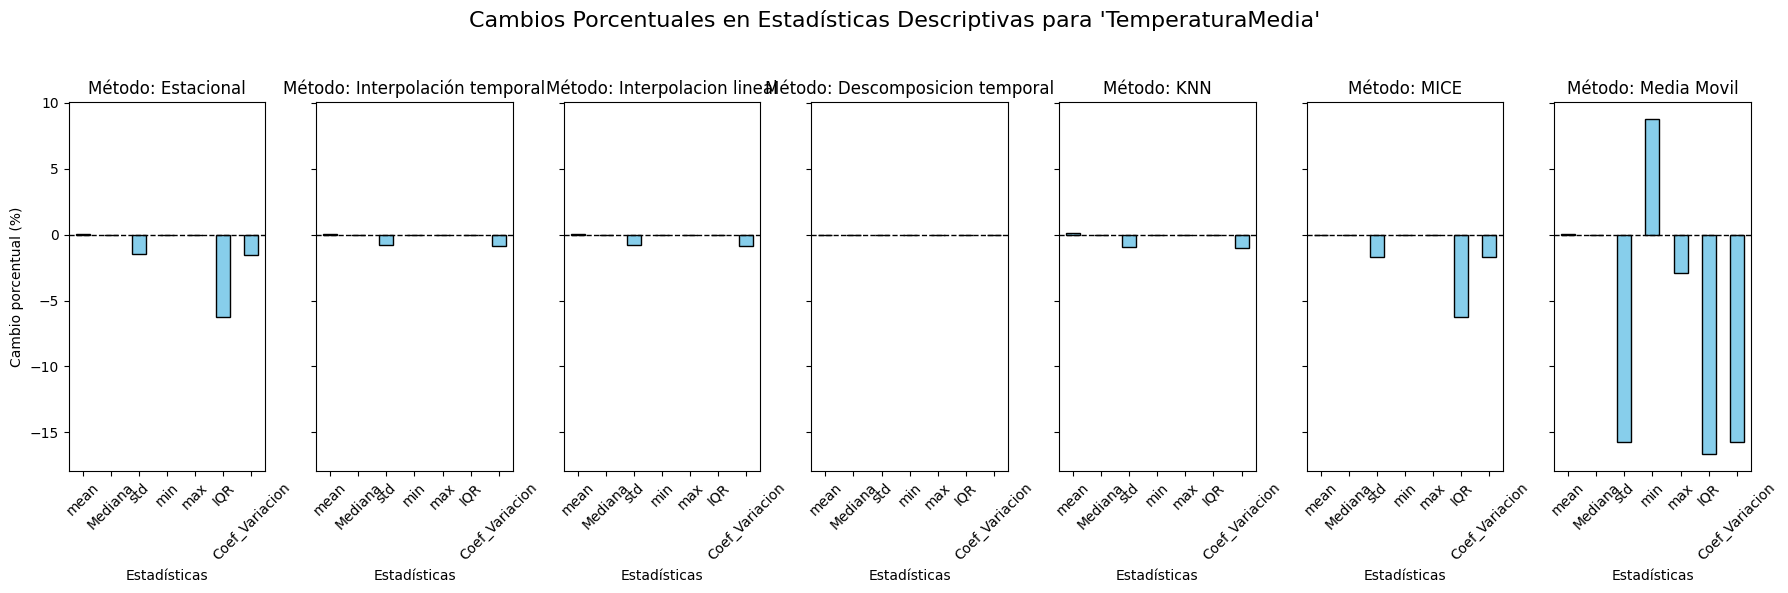

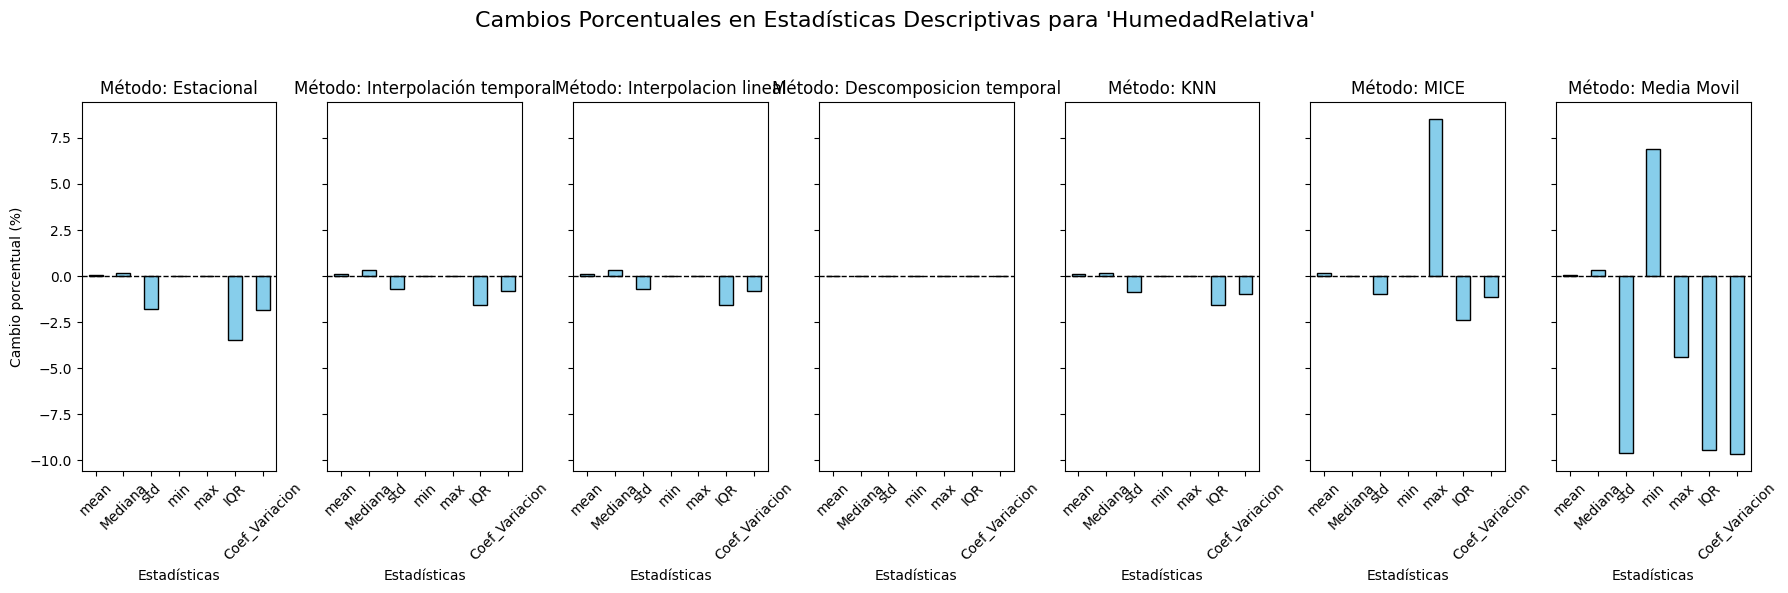

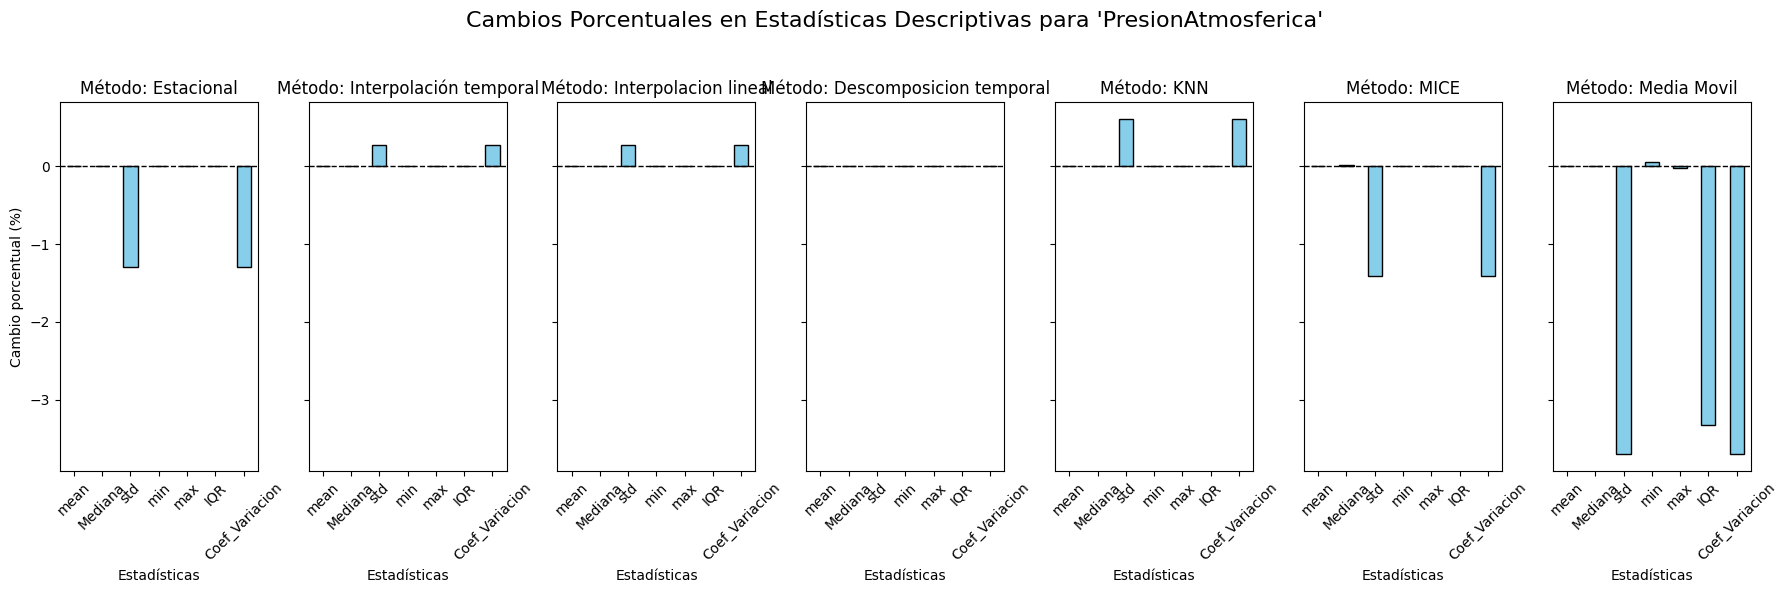

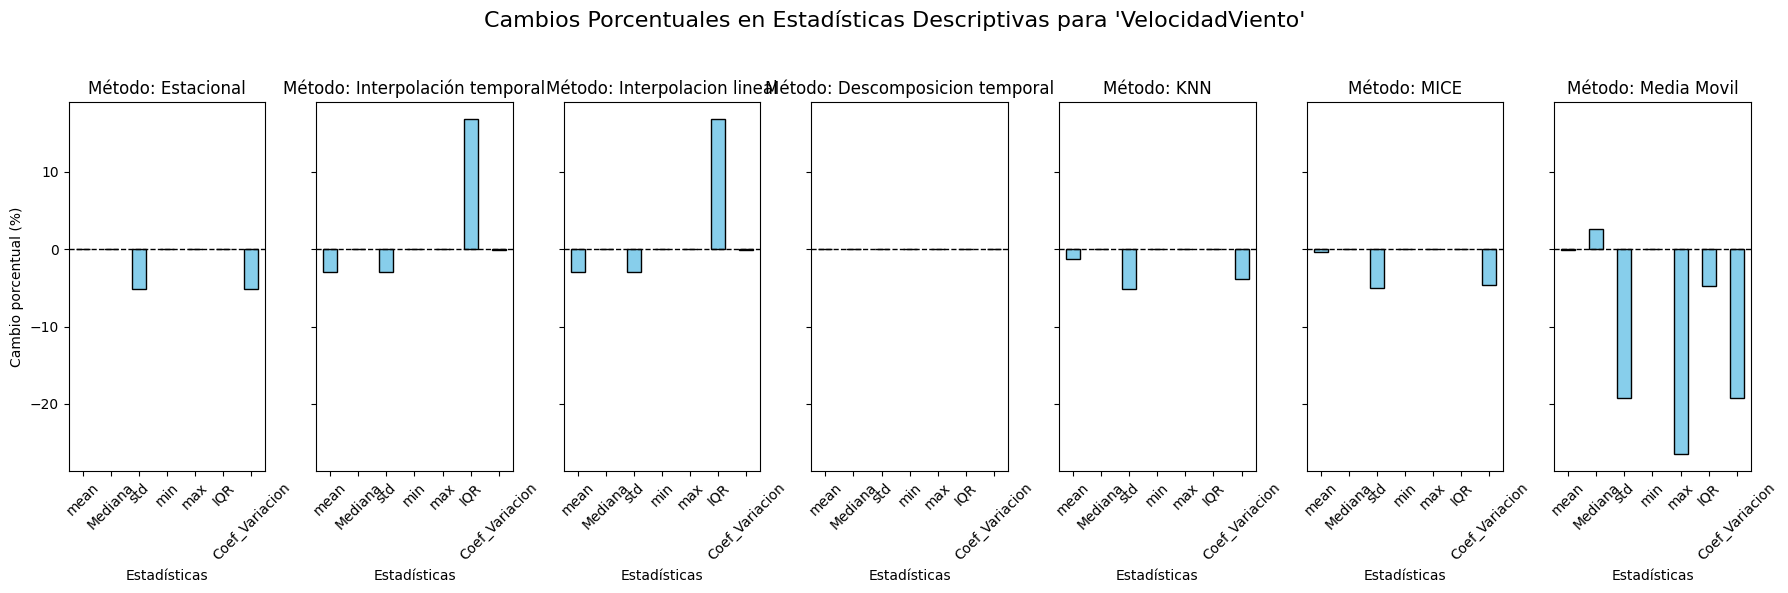

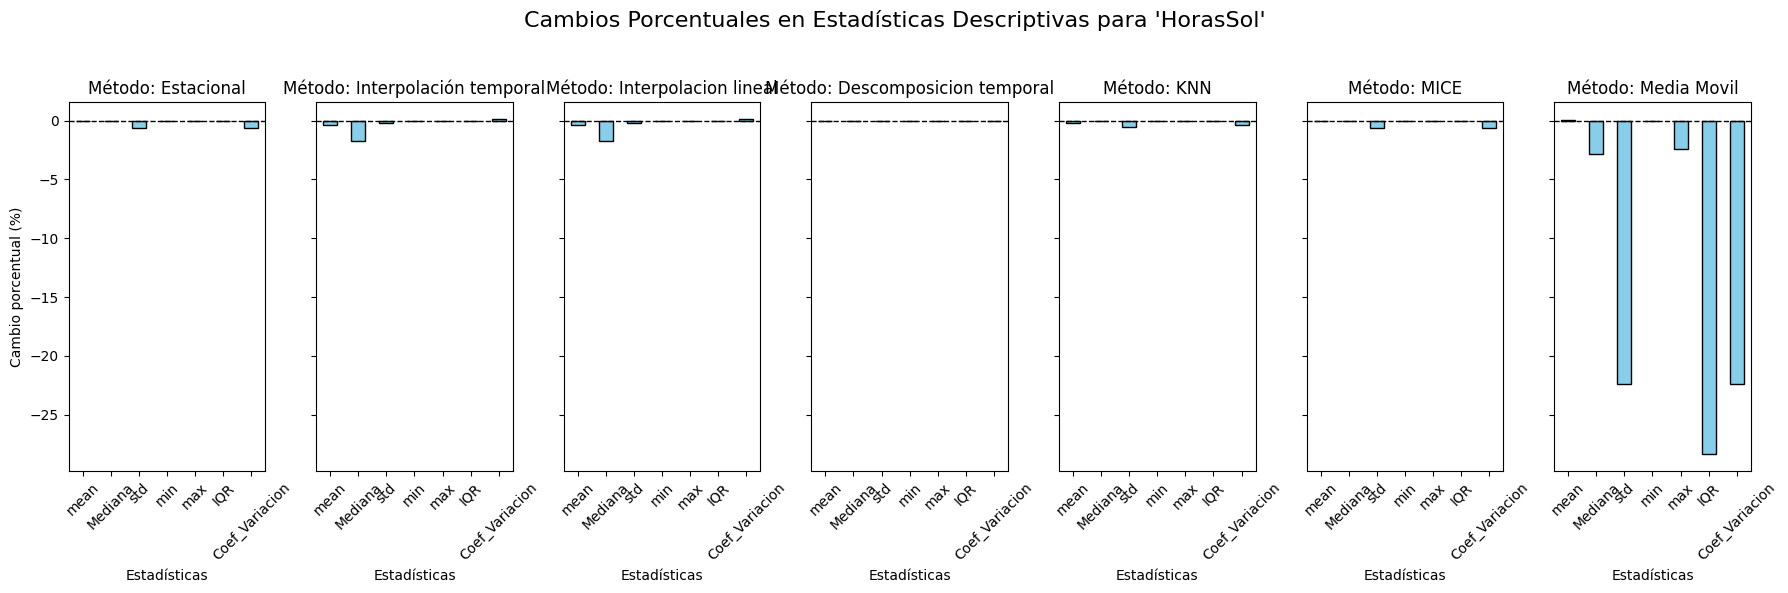

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew

def filtrar_variables_ambientales(df):
    """Excluye las columnas 'Year', 'Month' y 'Day' para analizar solo las variables ambientales."""
    return df.drop(columns=["Year", "Month", "Day"], errors="ignore")

def calcular_estadisticas(df):
    """Calcula estadísticas descriptivas extendidas para cada variable numérica."""
    stats = df.describe().T
    stats["Mediana"] = df.median()
    #stats["Curtosis"] = df.apply(kurtosis)
    #stats["Asimetría"] = df.apply(skew)
    stats["IQR"] = stats["75%"] - stats["25%"]
    stats["Coef_Variacion"] = stats["std"] / stats["mean"]
    #return stats[["mean", "Mediana", "std", "min", "max", "IQR", "Coef_Variacion", "Curtosis", "Asimetría"]]
    return stats[["mean", "Mediana", "std", "min", "max", "IQR", "Coef_Variacion"]]

def evaluar_cambios_estadisticos(df_original, df_imputado):
    """Compara estadísticas antes y después de la imputación en variables ambientales."""
    df_original = filtrar_variables_ambientales(df_original)
    df_imputado = filtrar_variables_ambientales(df_imputado)

    stats_antes = calcular_estadisticas(df_original)
    stats_despues = calcular_estadisticas(df_imputado)

    # Calcular diferencia porcentual
    cambios_pct = ((stats_despues - stats_antes) / stats_antes) * 100
    cambios_pct = cambios_pct.replace([np.inf, -np.inf], np.nan)

    return cambios_pct.round(2)

def graficar_cambios_por_variable(cambios_dict, variable):
    """Genera gráficos de barras para las diferencias porcentuales de una variable específica en cada método de imputación."""
    fig, axes = plt.subplots(1, len(cambios_dict), figsize=(18, 6), sharey=True)
    fig.suptitle(f"Cambios Porcentuales en Estadísticas Descriptivas para '{variable}'", fontsize=16)

    for ax, (metodo, cambios) in zip(axes, cambios_dict.items()):
        if variable in cambios.index:
            cambios_var = cambios.loc[variable]
            cambios_var.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
            ax.axhline(0, color='black', linewidth=1, linestyle='--')
            ax.set_title(f"Método: {metodo}")
            ax.set_ylabel("Cambio porcentual (%)")
            ax.set_xlabel("Estadísticas")
            ax.tick_params(axis='x', rotation=45)
        else:
            ax.set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Ejemplo de uso:

# Evaluar cambios estadísticos para cada método de imputación
cambios_pct_estacional = evaluar_cambios_estadisticos(df_procesado, df_imputacion_estacional)
cambios_pct_interpolacion_temporal = evaluar_cambios_estadisticos(df_procesado, df_imputacion_interpolacion_temporal)
cambios_pct_interpolacion_lineal = evaluar_cambios_estadisticos(df_procesado, df_imputacion_interpolacion_lineal)
cambios_pct_descomposicion_temporal = evaluar_cambios_estadisticos(df_procesado,df_imputacion_descomposicion_temporal )
cambios_pct_knn = evaluar_cambios_estadisticos(df_procesado, df_imputacion_knn)
cambios_pct_mice = evaluar_cambios_estadisticos(df_procesado, df_imputacion_mice)
cambios_pct_media_movil = evaluar_cambios_estadisticos(df_procesado, df_imputacion_media_movil)

# Almacenar los cambios en un diccionario para facilitar el acceso
cambios_dict = {
    'Estacional': cambios_pct_estacional,
    'Interpolación temporal': cambios_pct_interpolacion_temporal,
    'Interpolacion lineal': cambios_pct_interpolacion_lineal,
    'Descomposicion temporal': cambios_pct_descomposicion_temporal,
    'KNN': cambios_pct_knn,
    'MICE': cambios_pct_mice,
    'Media Movil': cambios_pct_media_movil
}

# Lista de variables a analizar
variables_a_analizar = ['PrecipitacionDiaria', 'TemperaturaMedia', 'HumedadRelativa',
                      'PresionAtmosferica', 'VelocidadViento', 'HorasSol']

# Generar gráficos para cada variable
for variable in variables_a_analizar:
    graficar_cambios_por_variable(cambios_dict, variable)

## 2. EVALUACION DE LA DINAMICA TEMPORAL

Funciones de Autocorrelación:

* ACF (Función de Autocorrelación): Compara los gráficos ACF de la serie original e imputada para asegurarte de que se preserven las correlaciones a distintos rezagos.

* PACF (Función de Autocorrelación Parcial): Verifica que la dependencia directa entre observaciones se mantenga tras la imputación.

* EACF (Función de Autocorrelación Extendida): Es especialmente útil para identificar estructuras ARMA en series con componentes estacionales y no estacionales.

Preservación de Componentes de la Serie:

* Análisis de Descomposición: Utiliza métodos como STL o descomposición clásica para separar la serie en sus componentes (tendencia, estacionalidad y residual) antes y después de la imputación.

* Verifica que la amplitud y fase de los ciclos estacionales, así como la tendencia general, se mantengan, lo cual es crítico para variables como precipitación y temperatura.




Evaluación de la variable: PrecipitacionDiaria



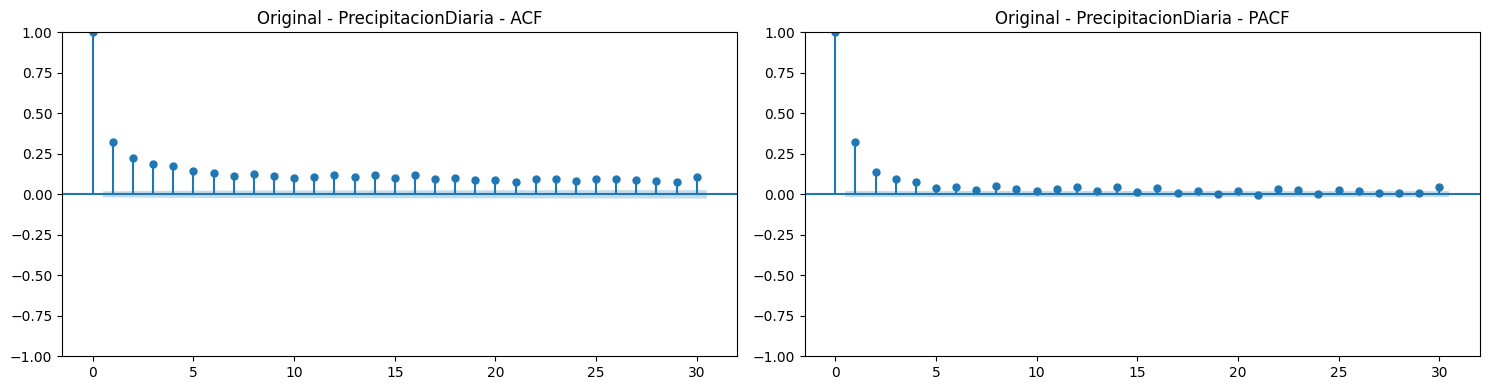

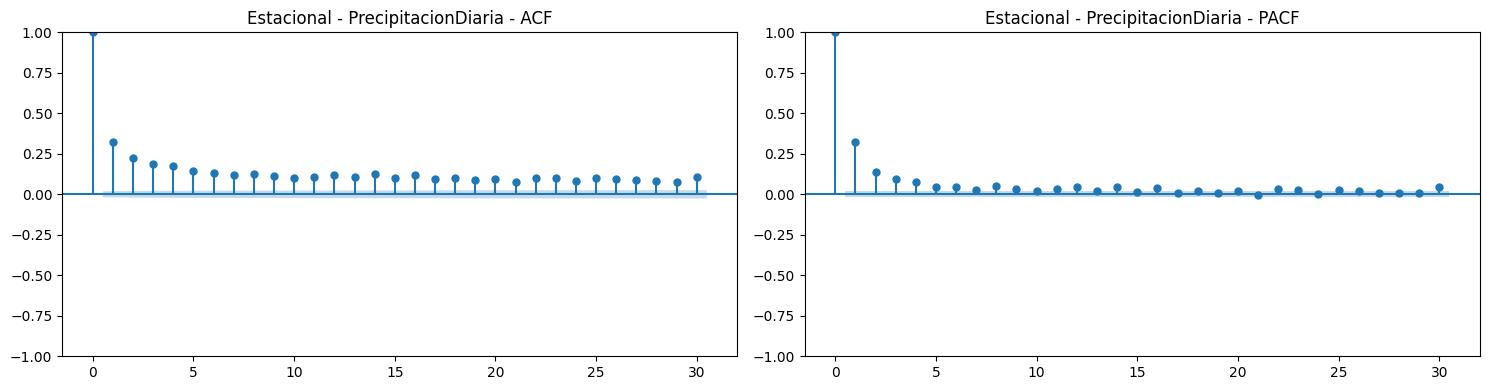

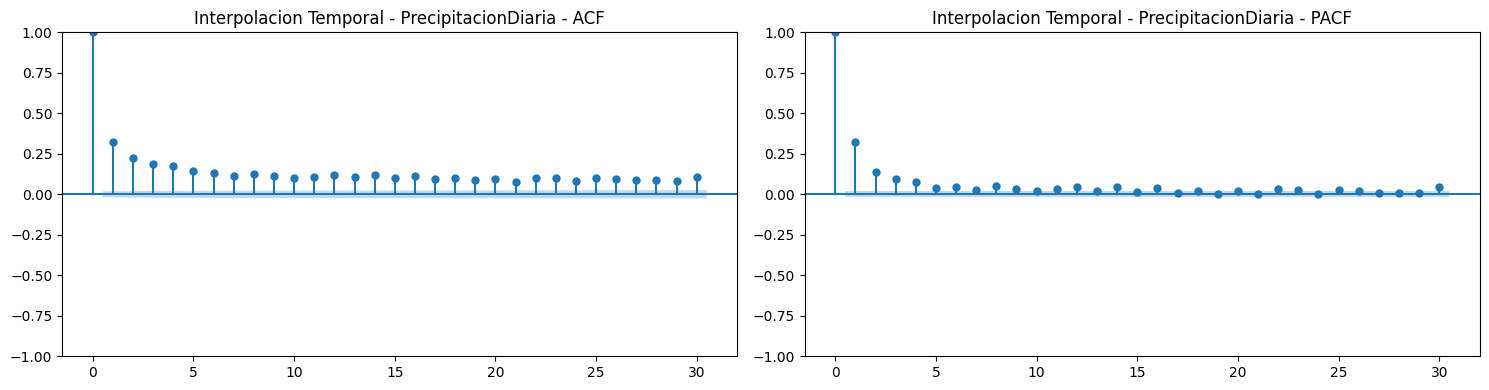

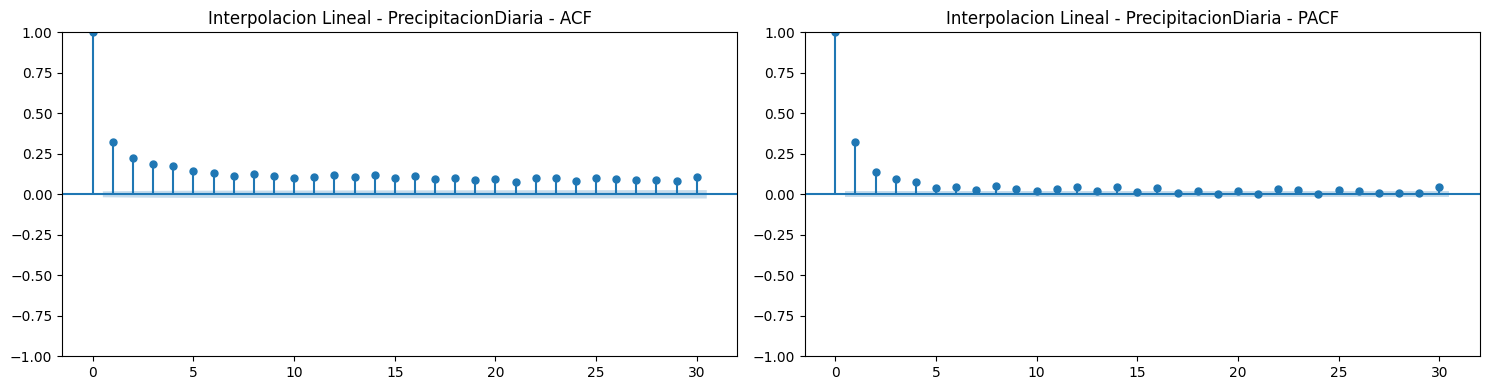

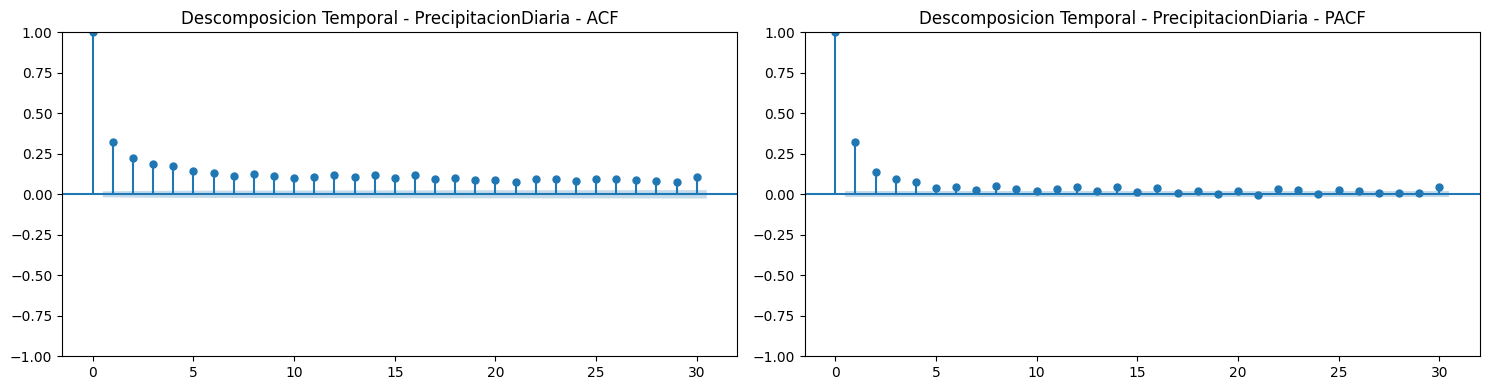

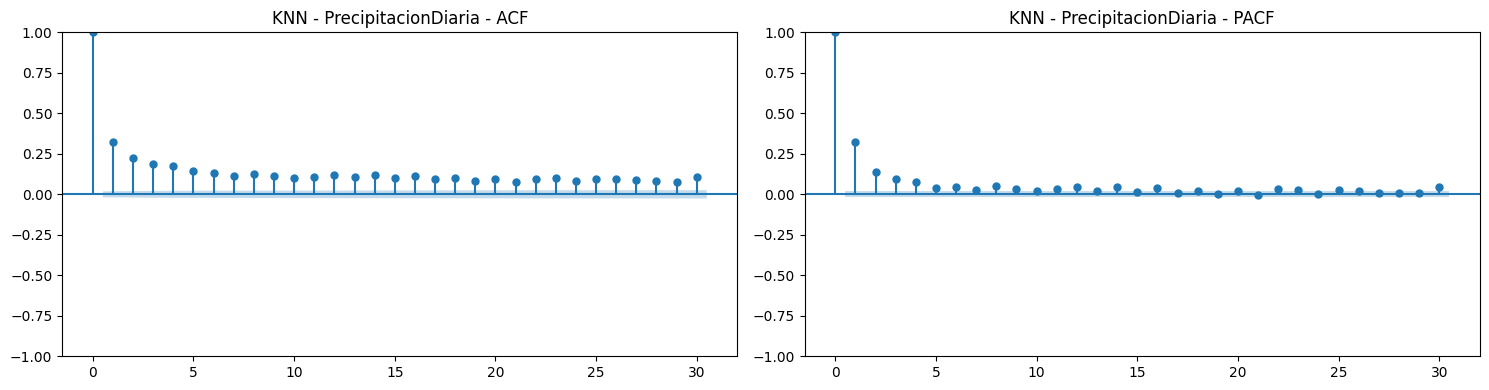

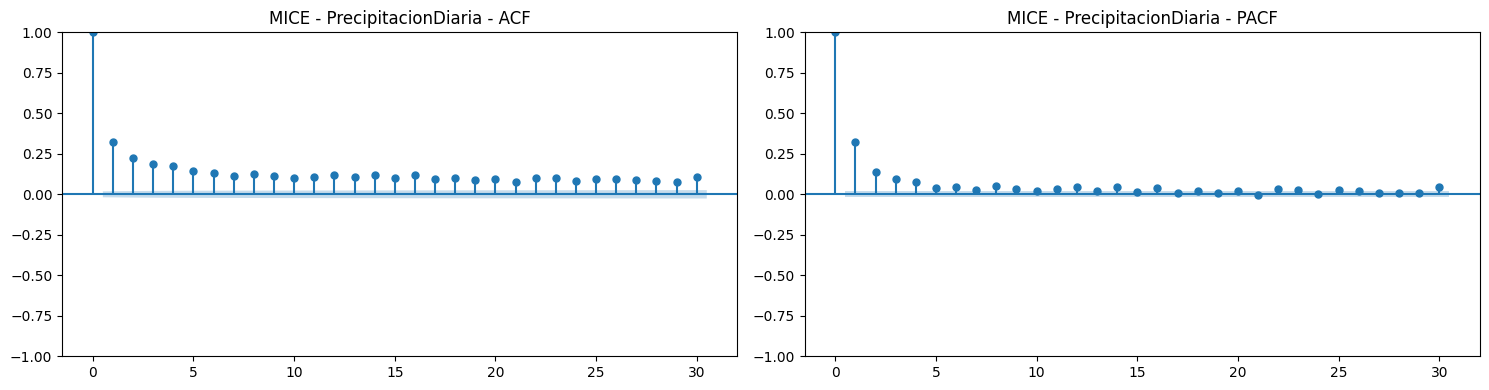

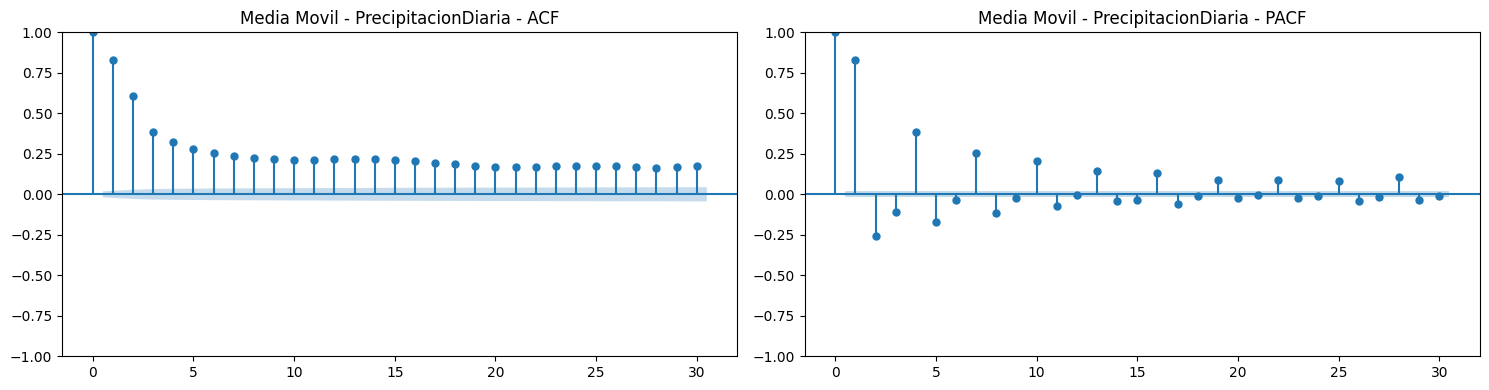

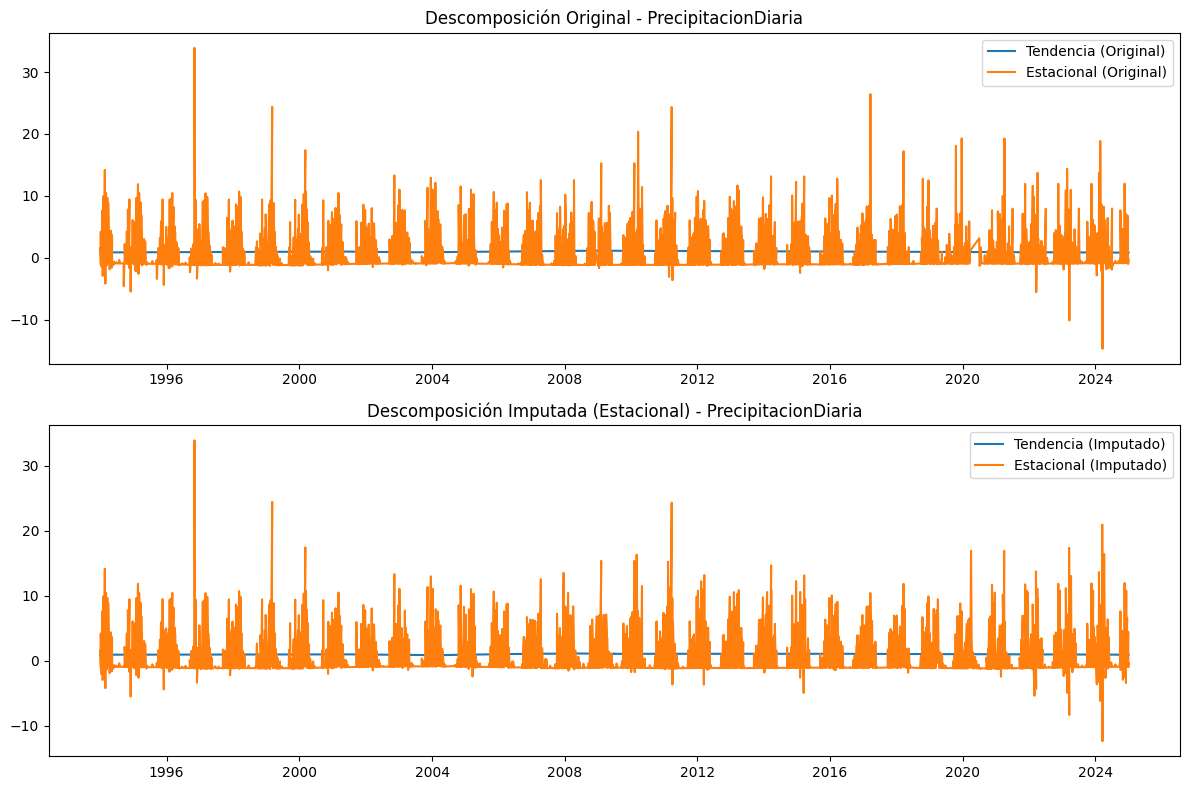


Evaluación de la variable: TemperaturaMedia



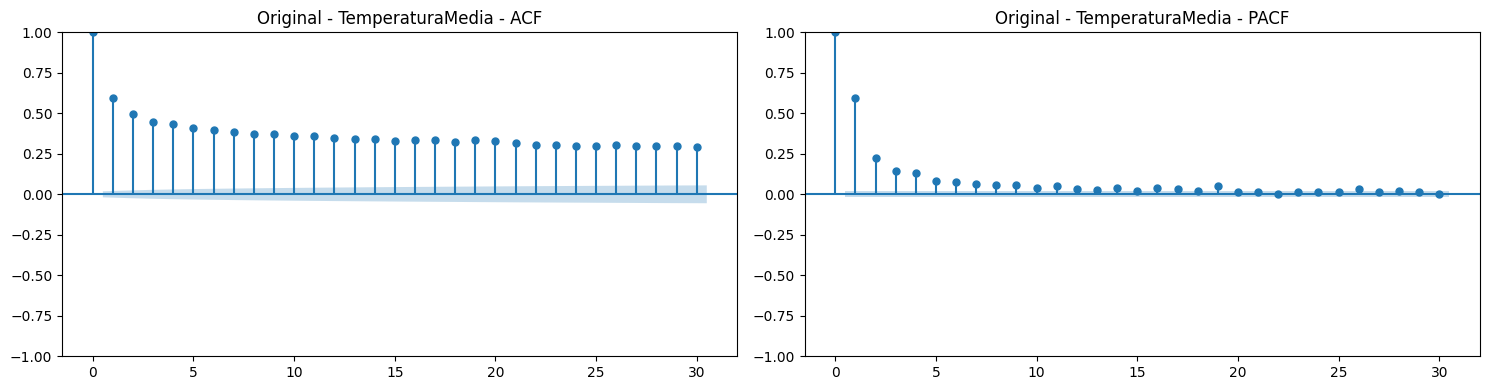

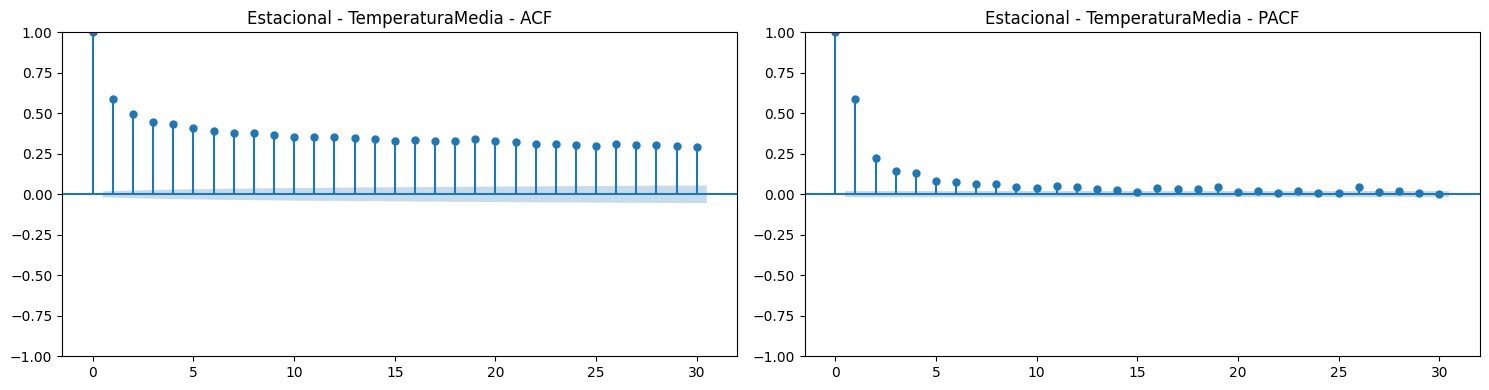

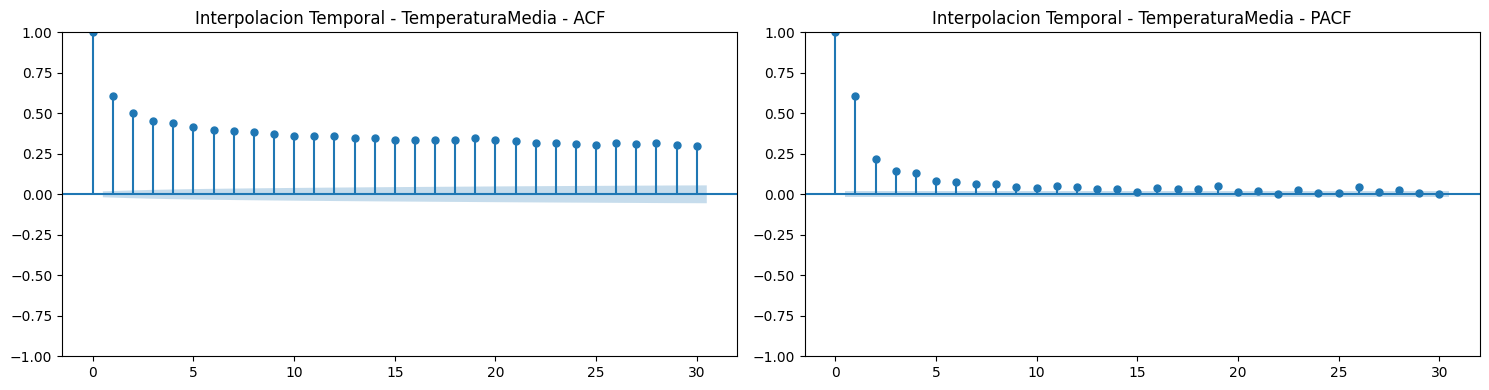

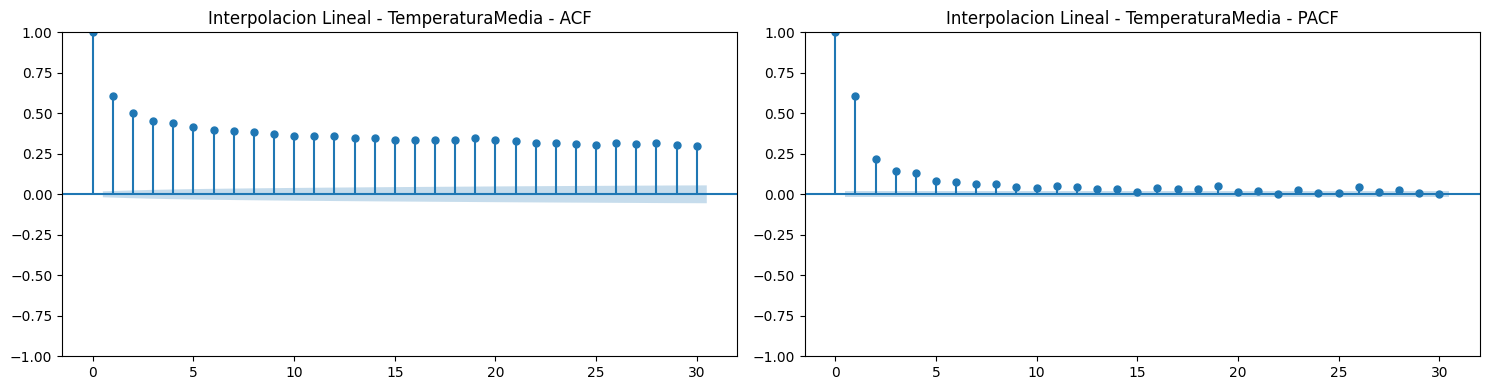

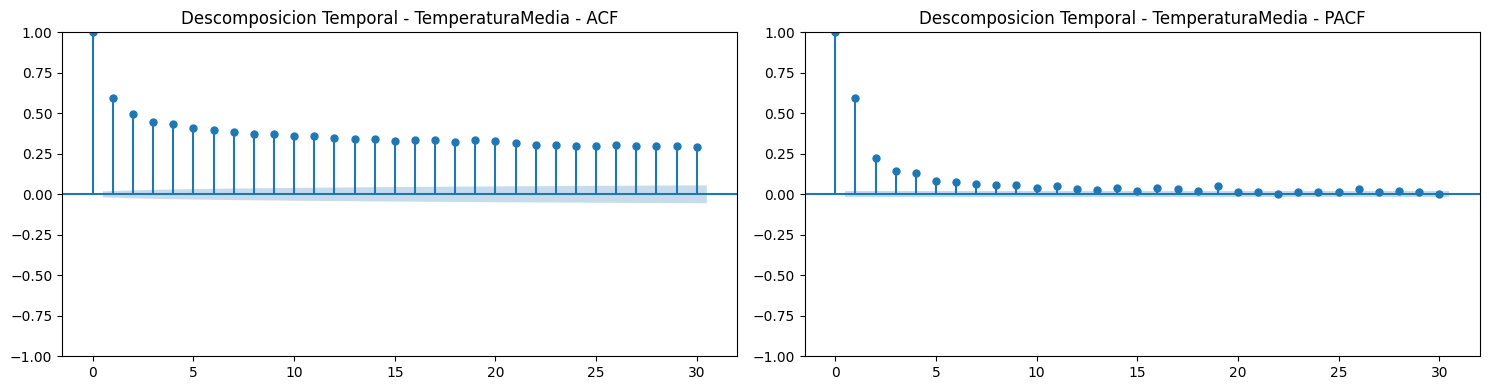

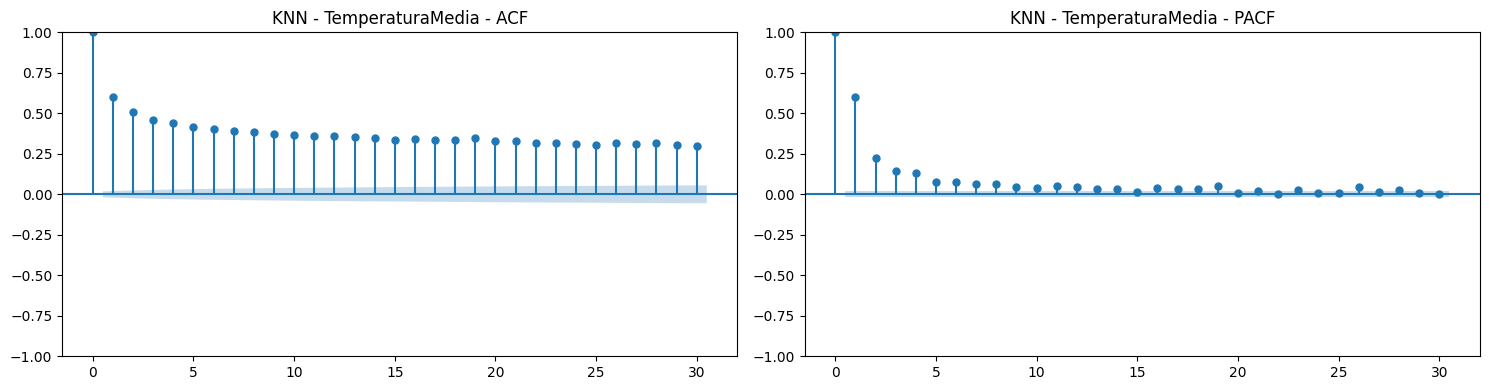

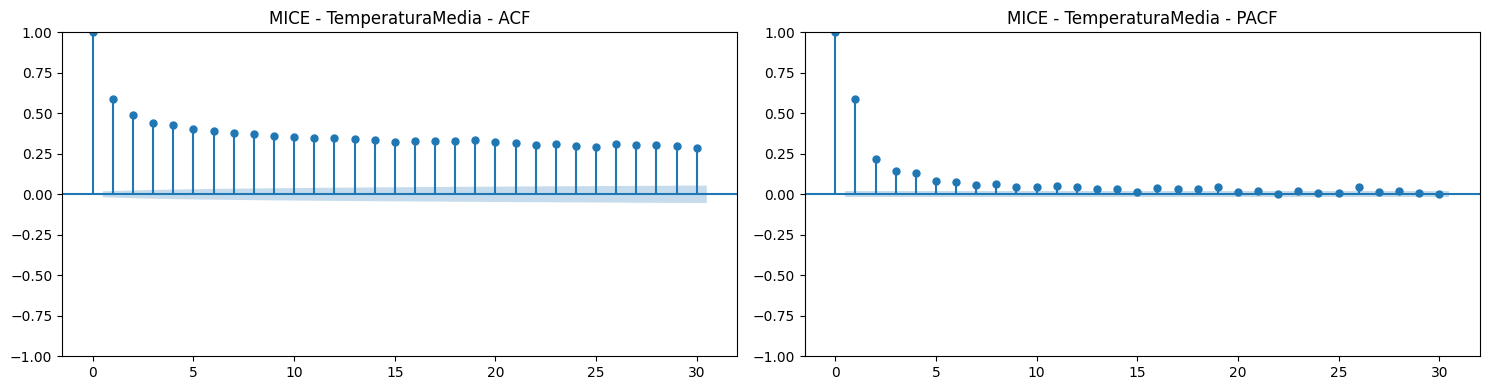

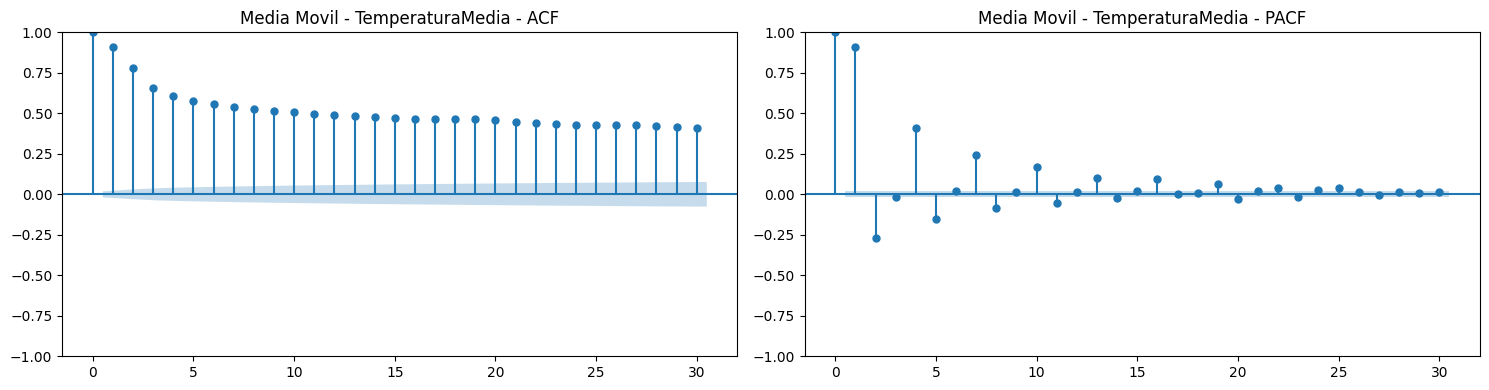

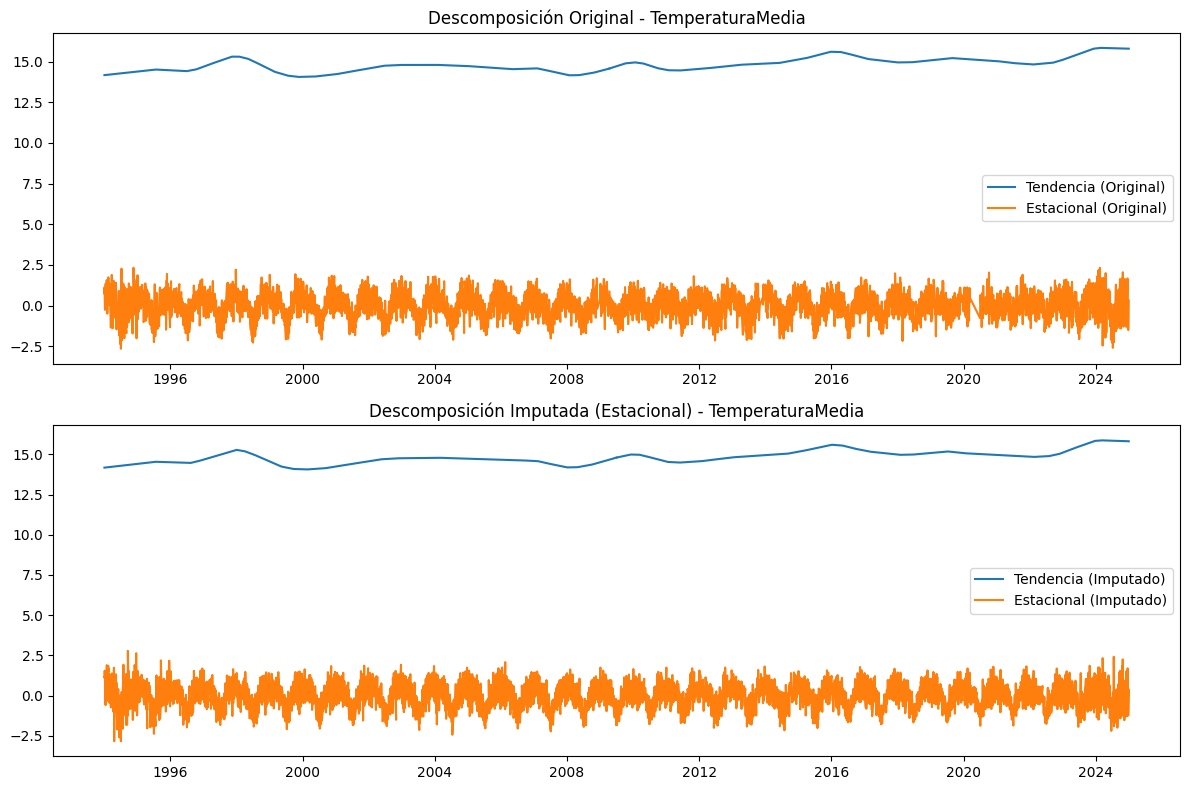


Evaluación de la variable: HumedadRelativa



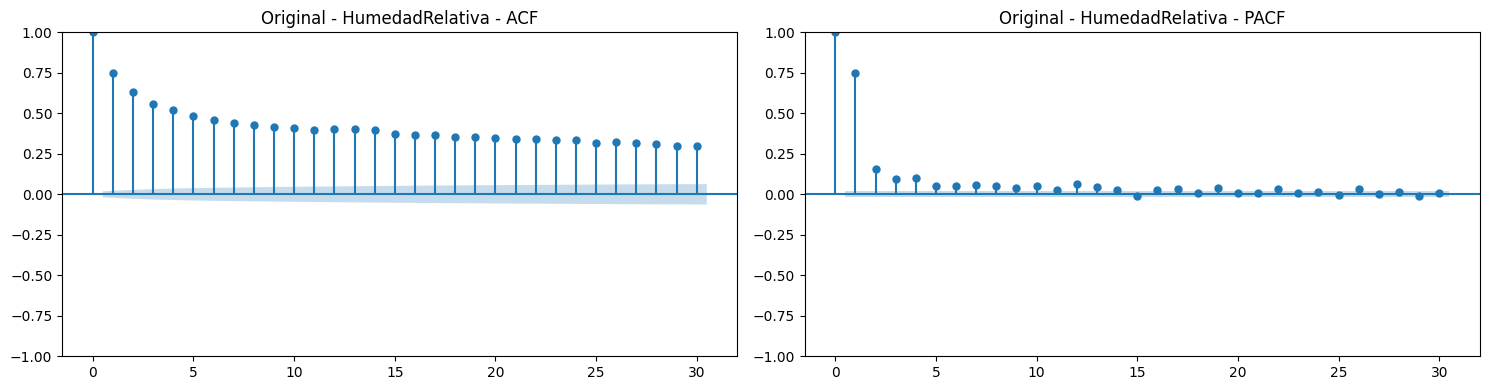

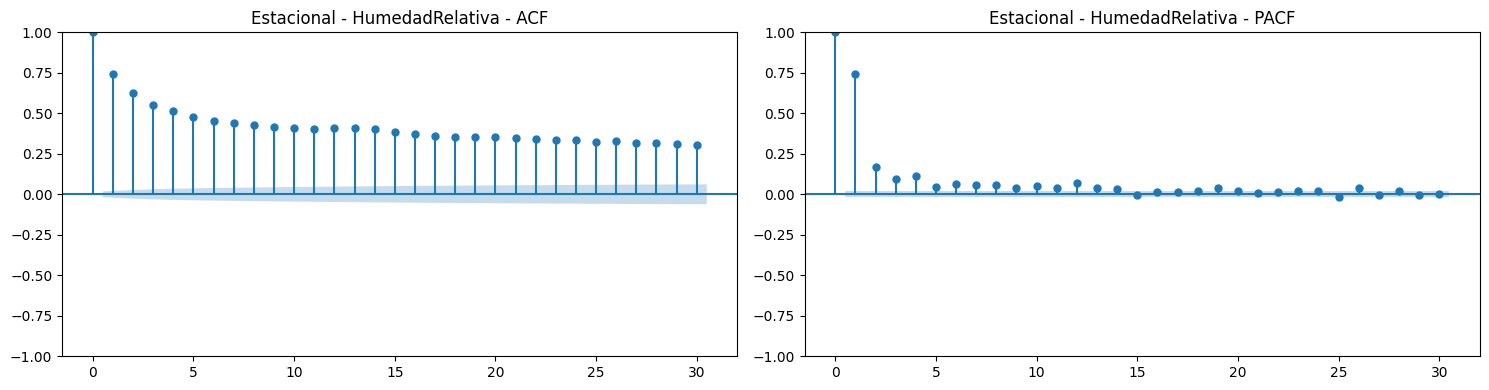

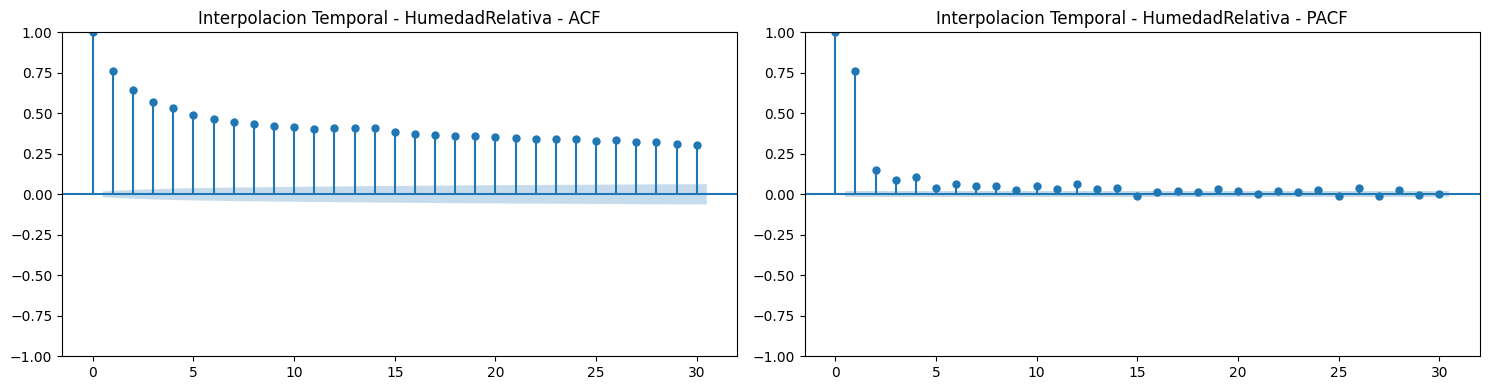

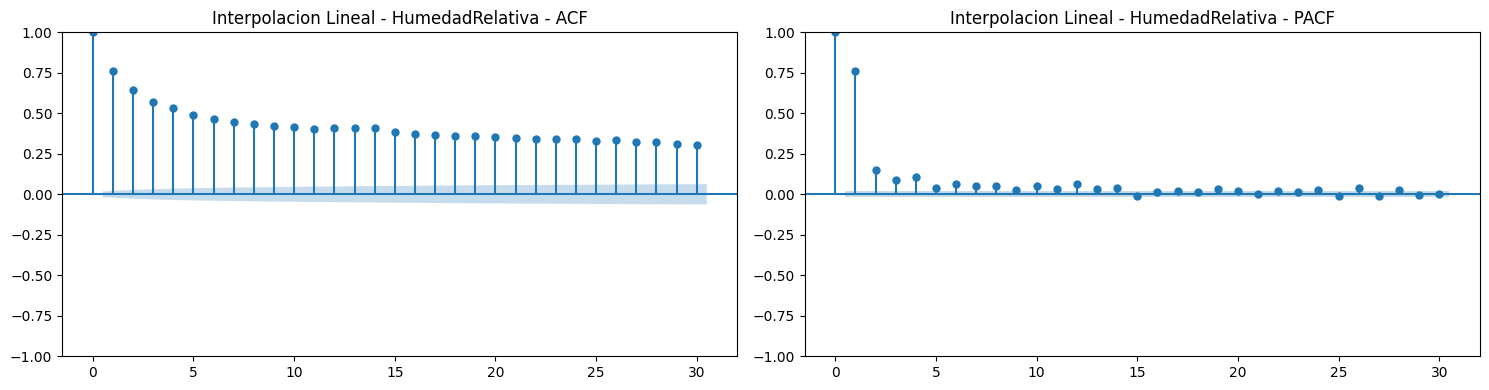

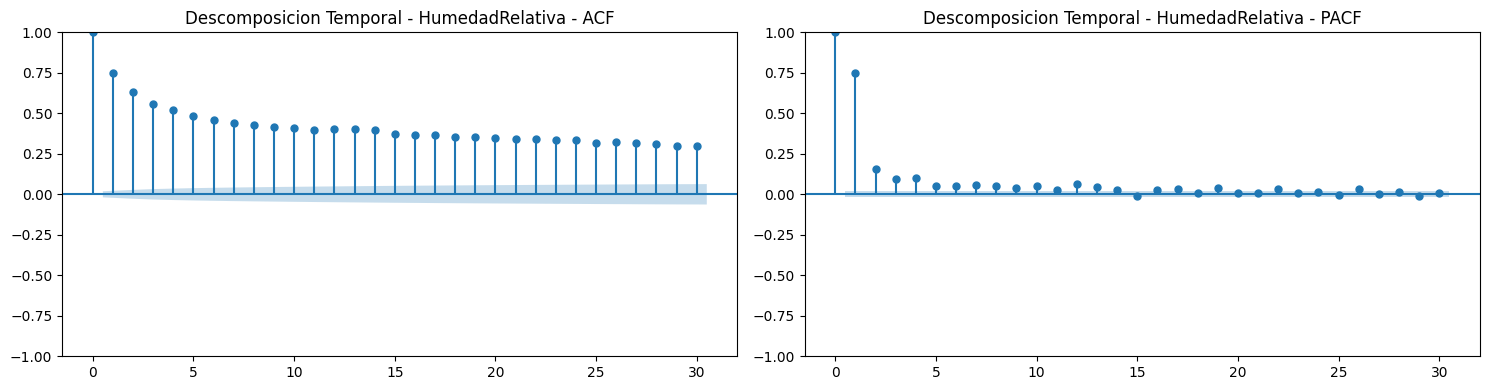

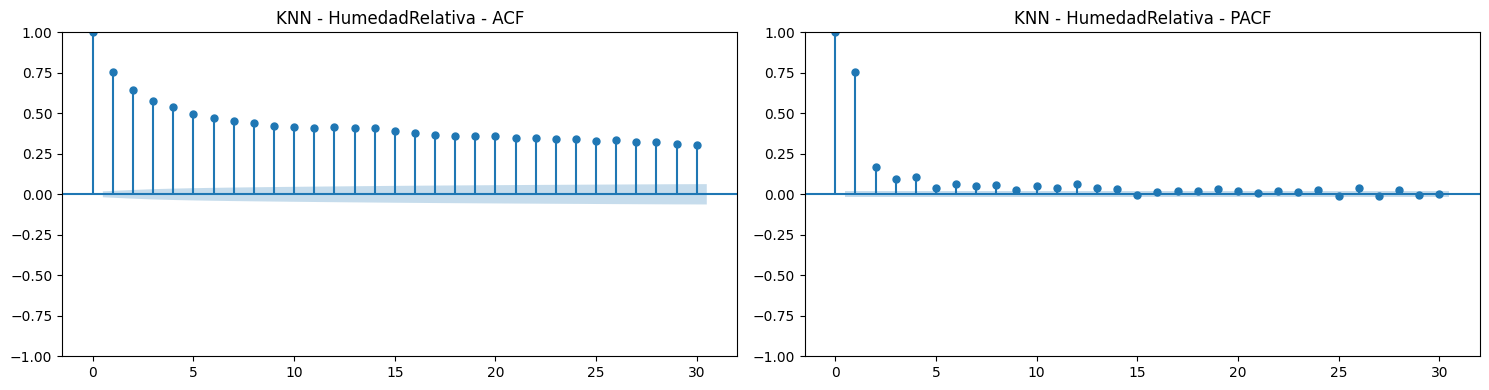

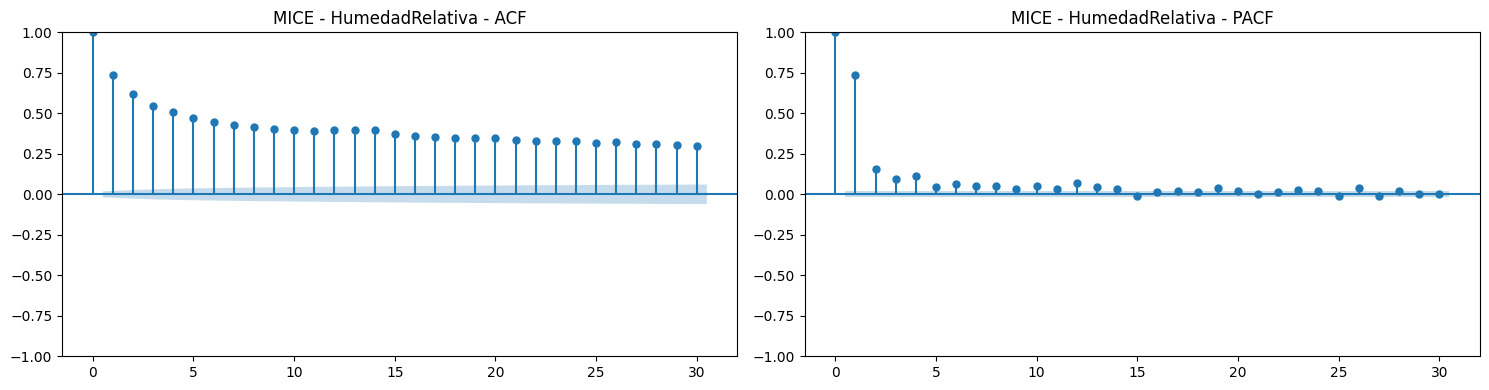

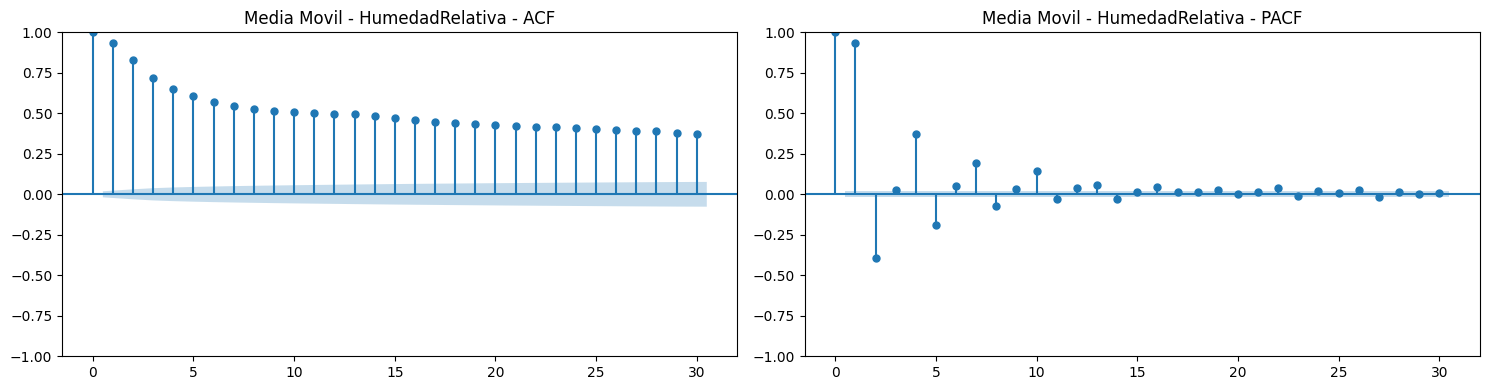

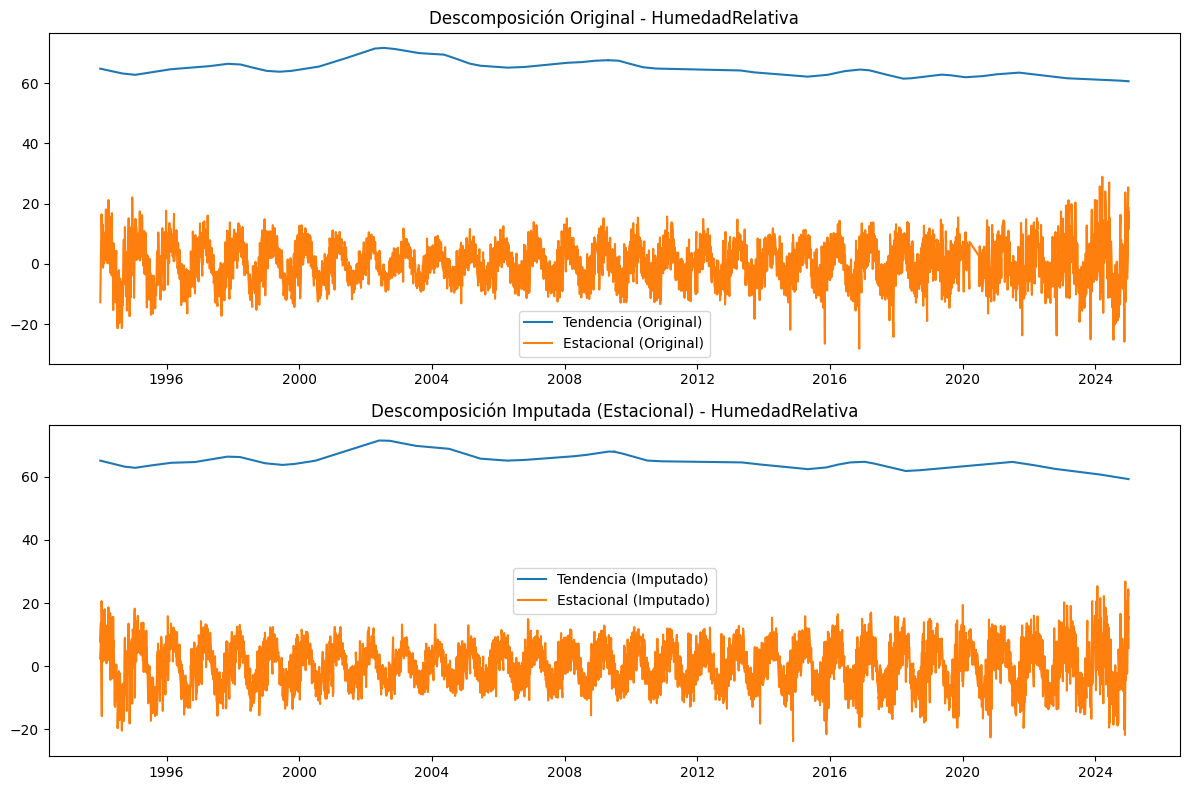


Evaluación de la variable: PresionAtmosferica



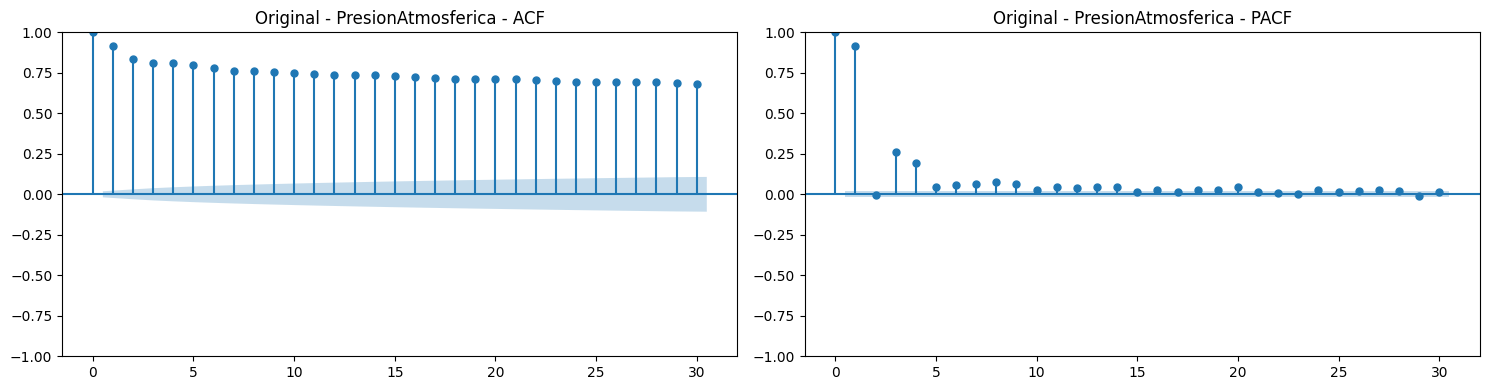

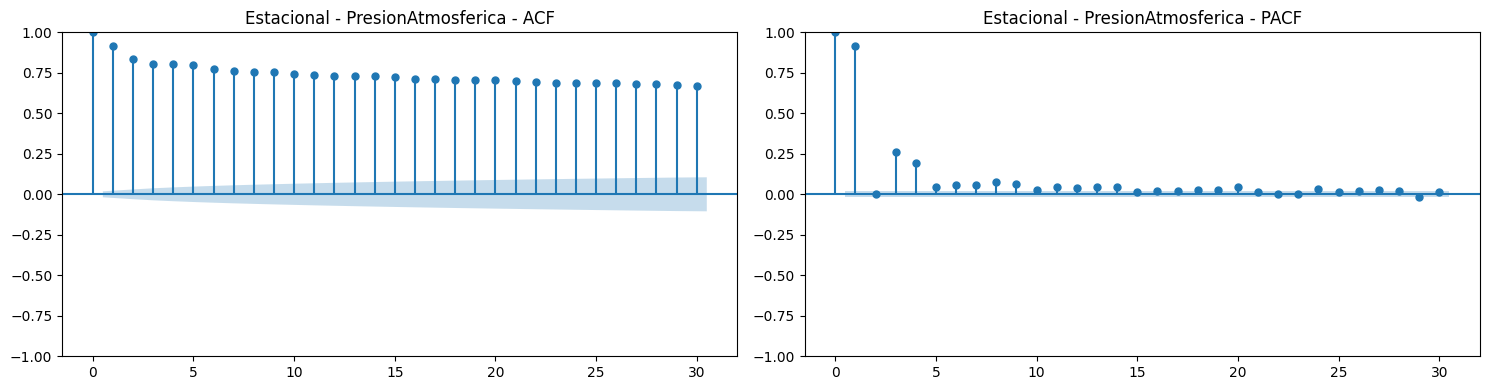

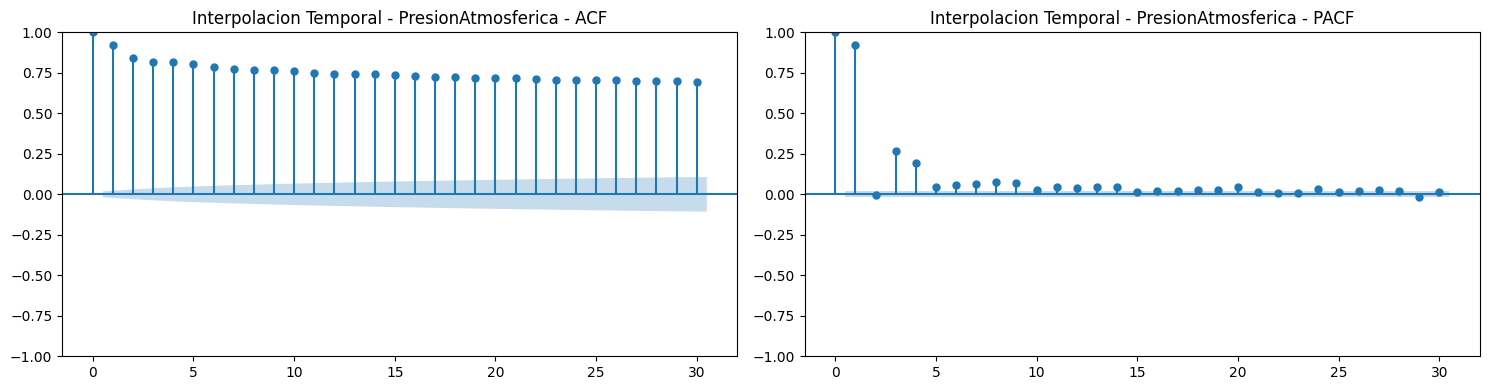

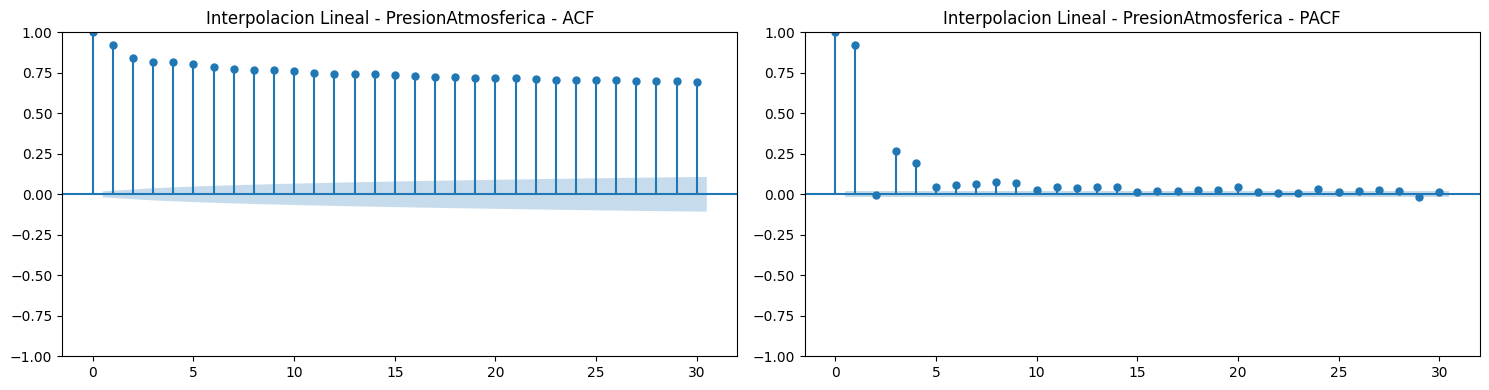

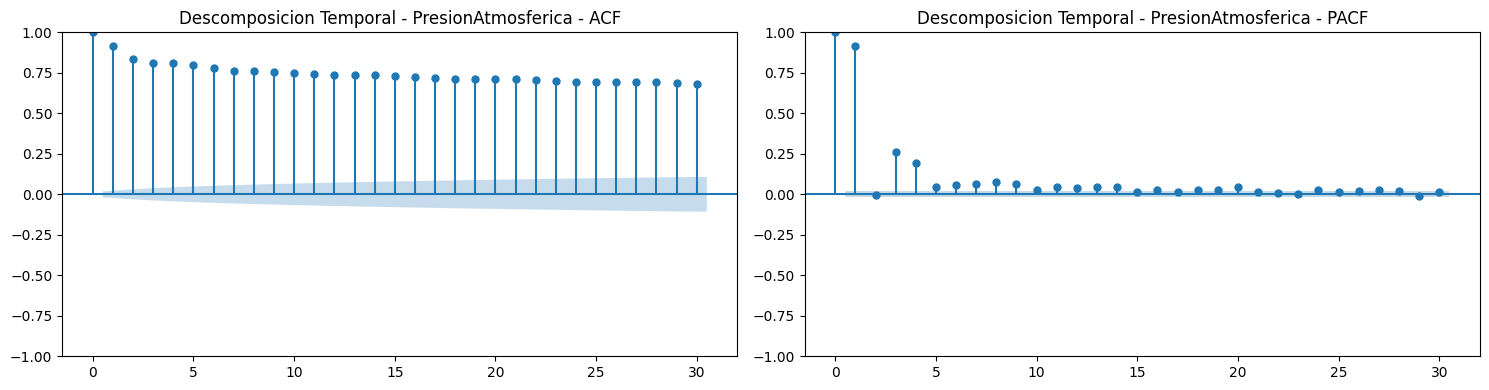

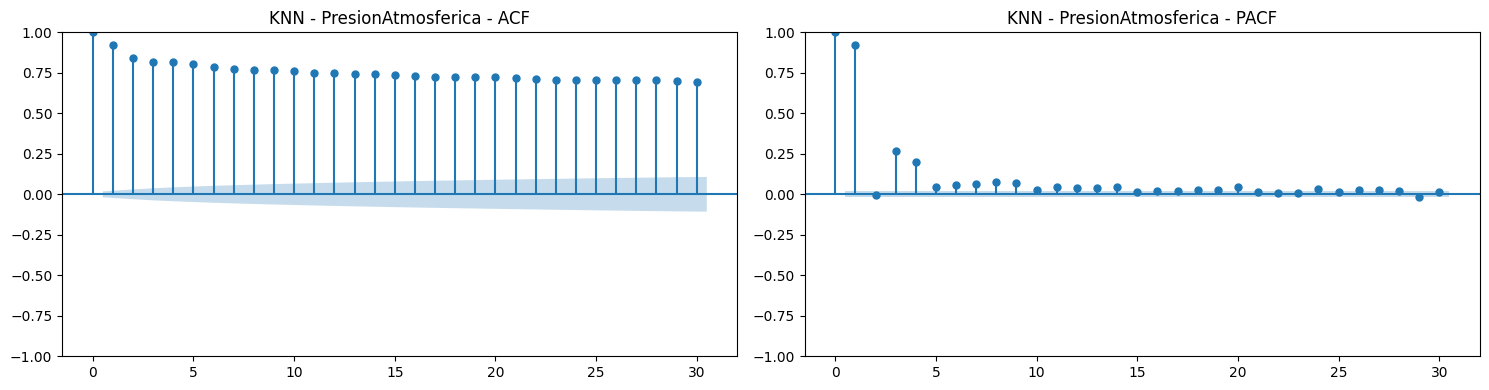

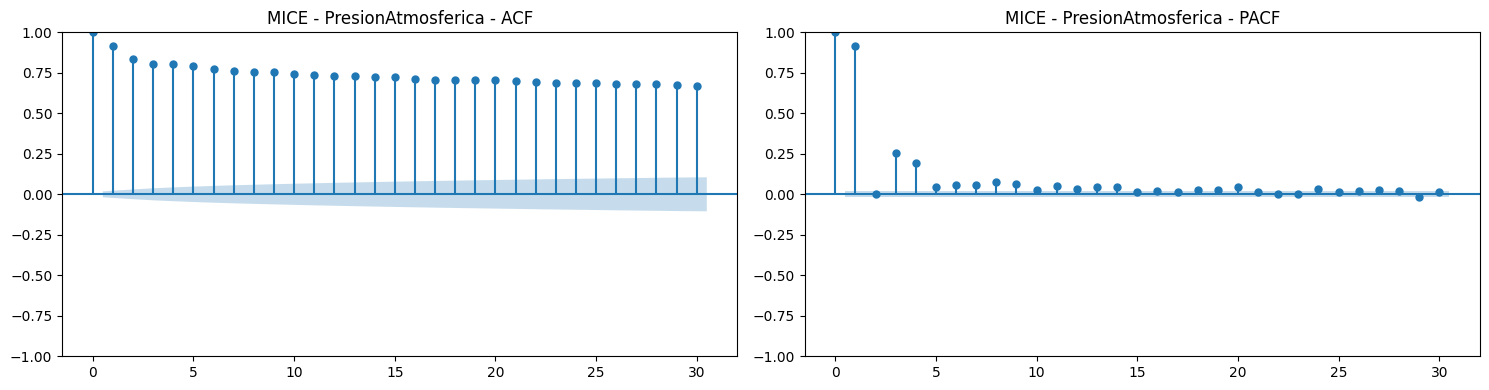

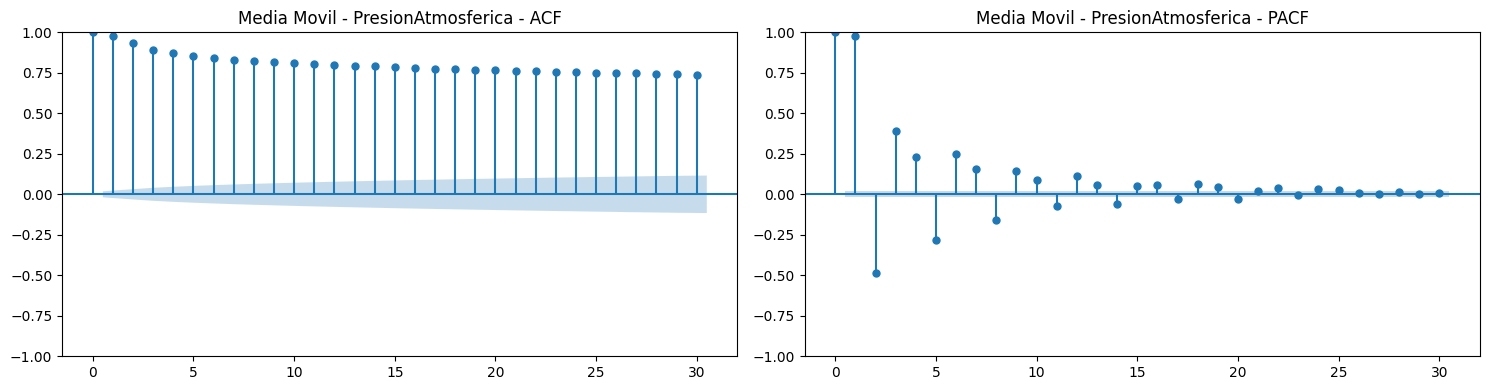

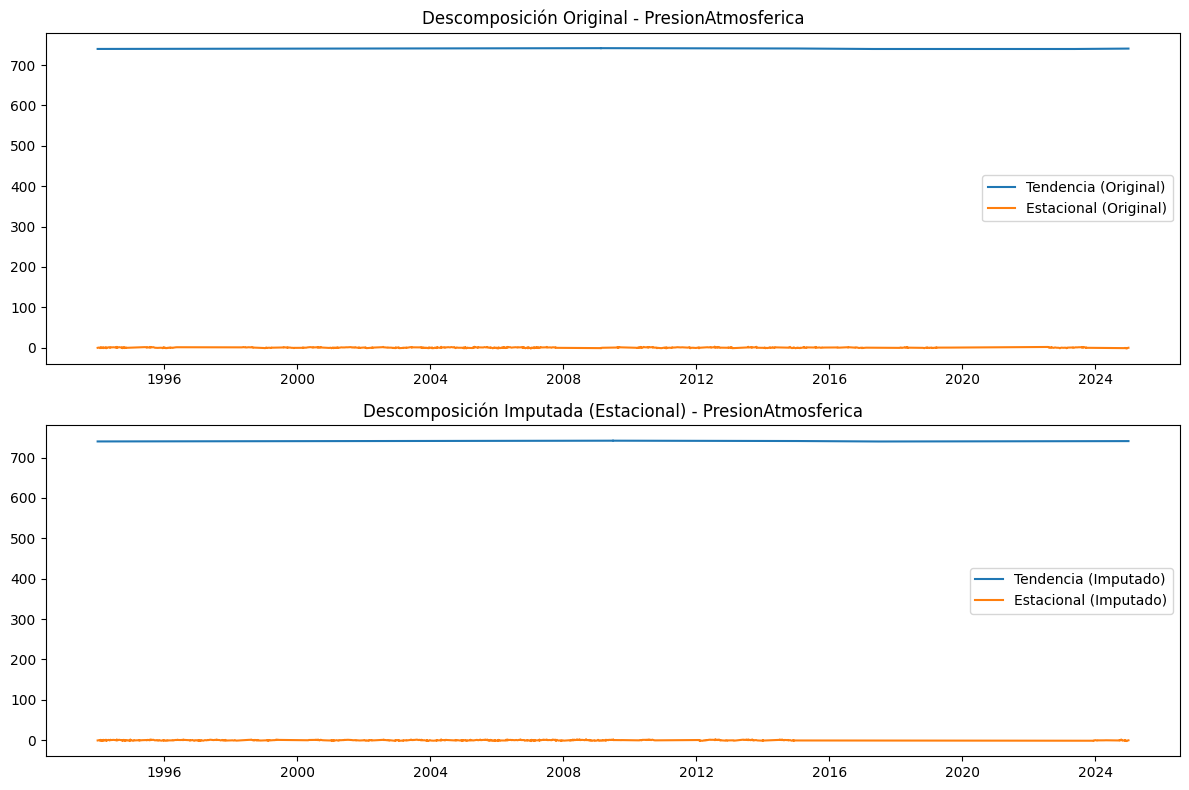


Evaluación de la variable: VelocidadViento



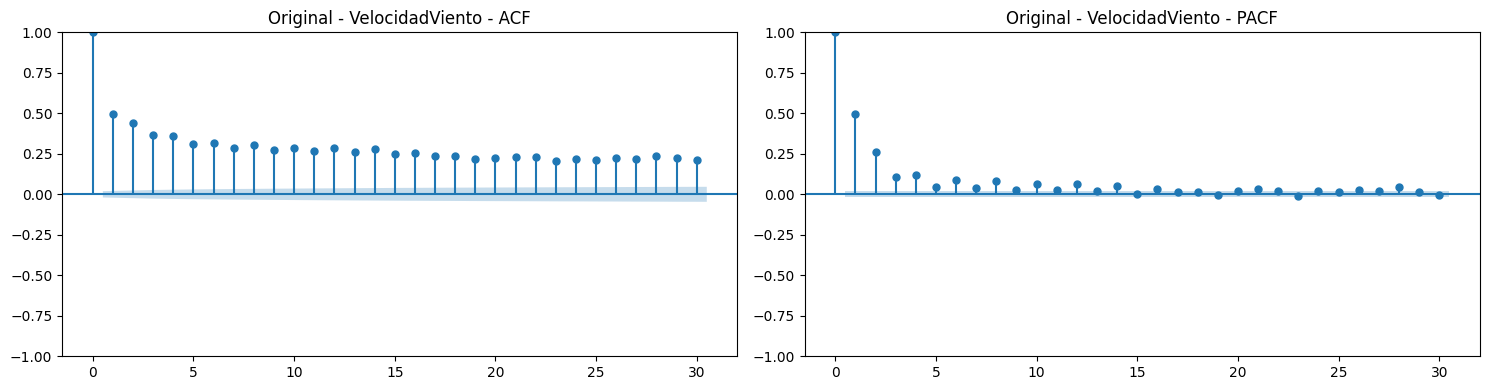

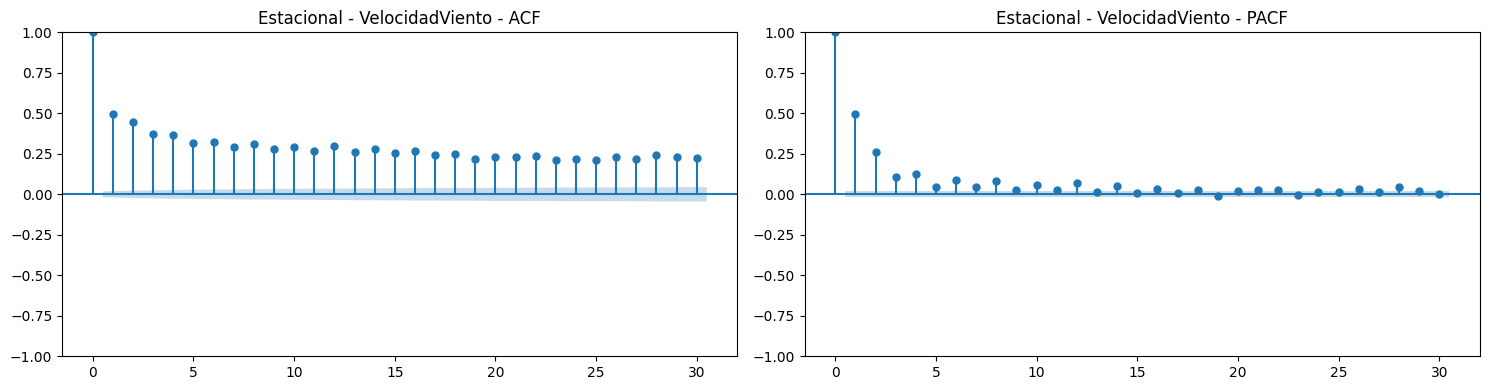

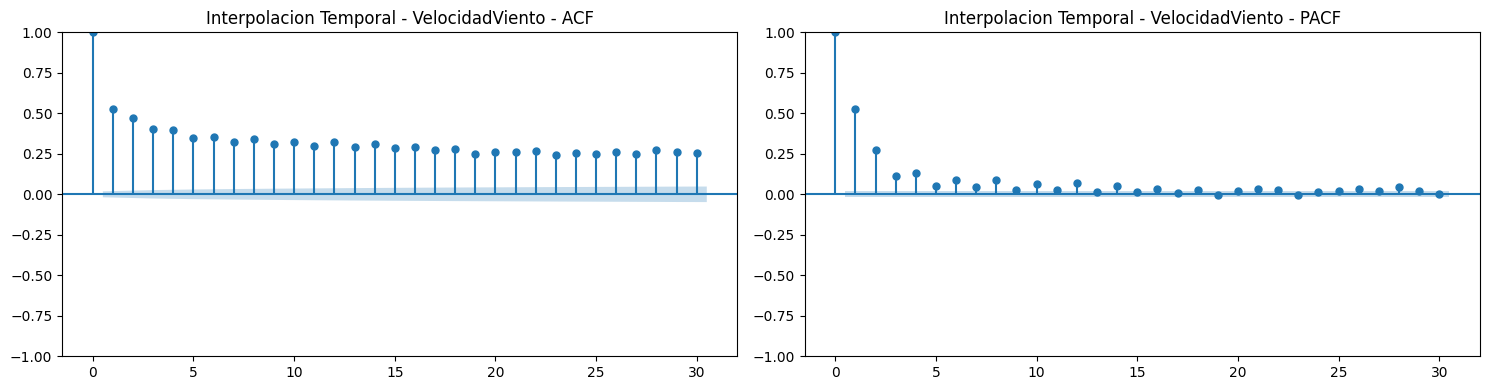

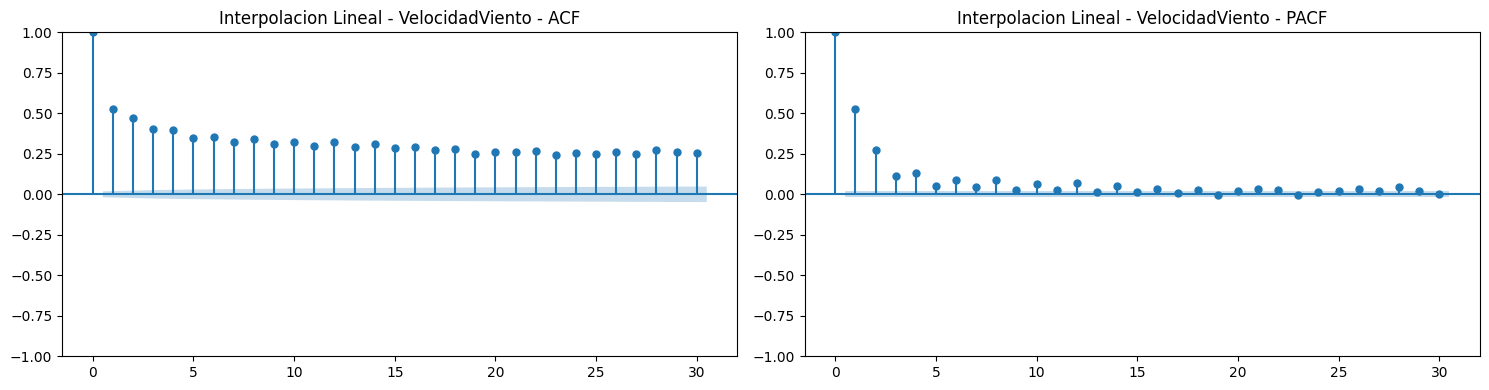

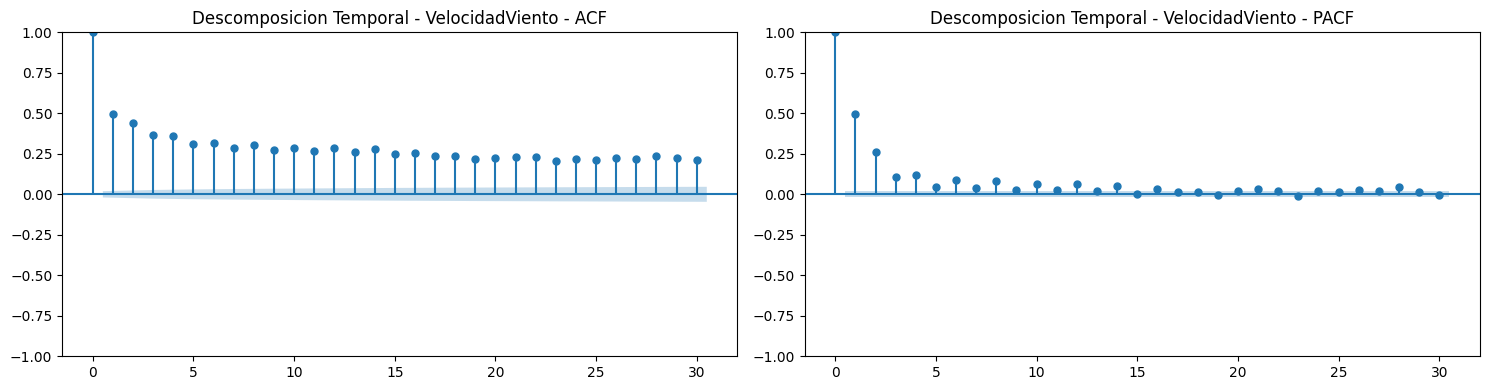

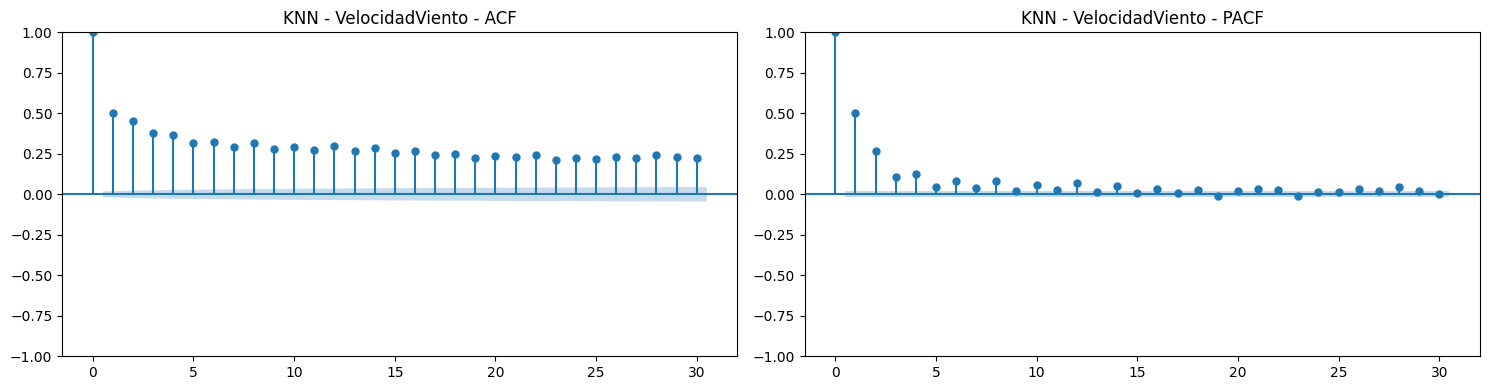

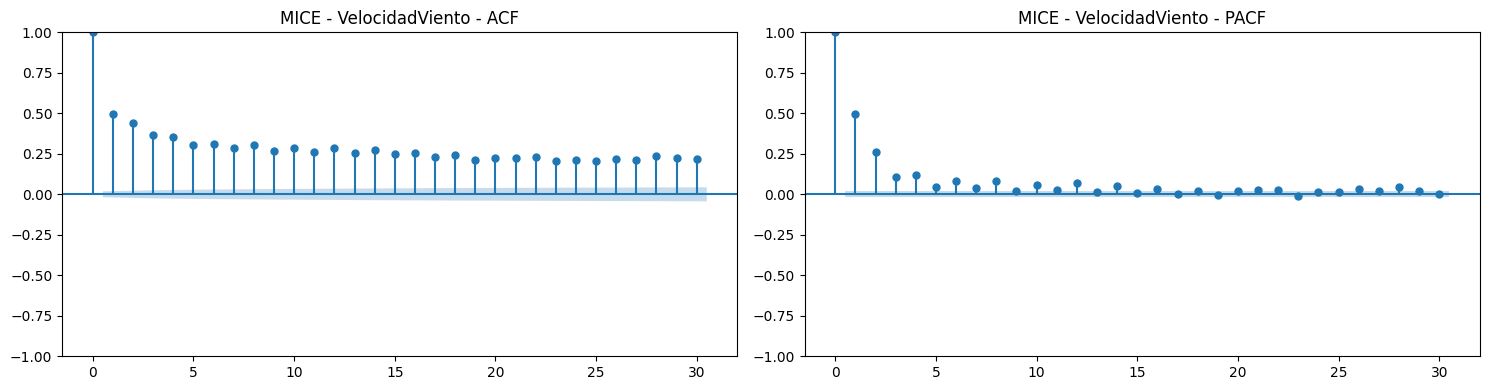

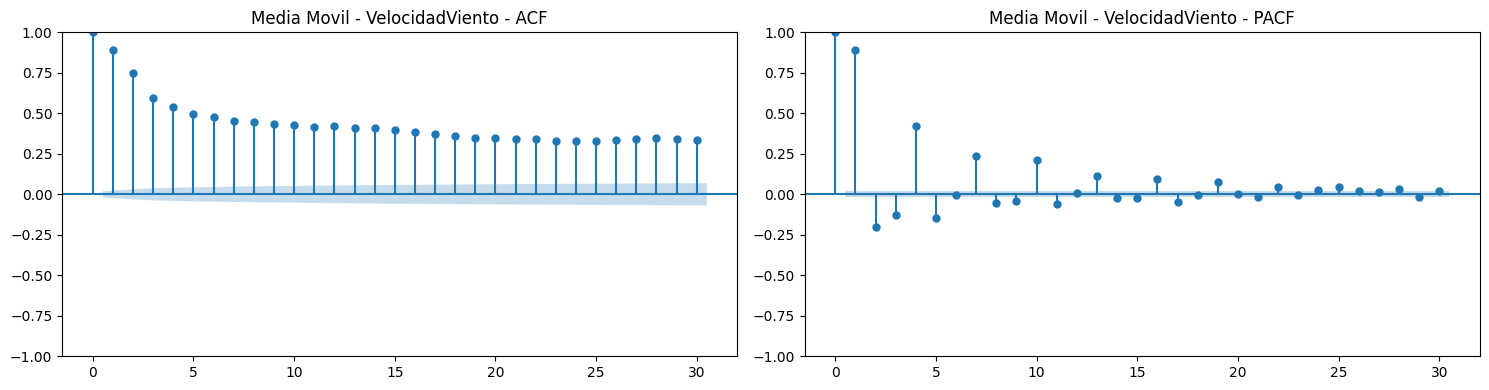

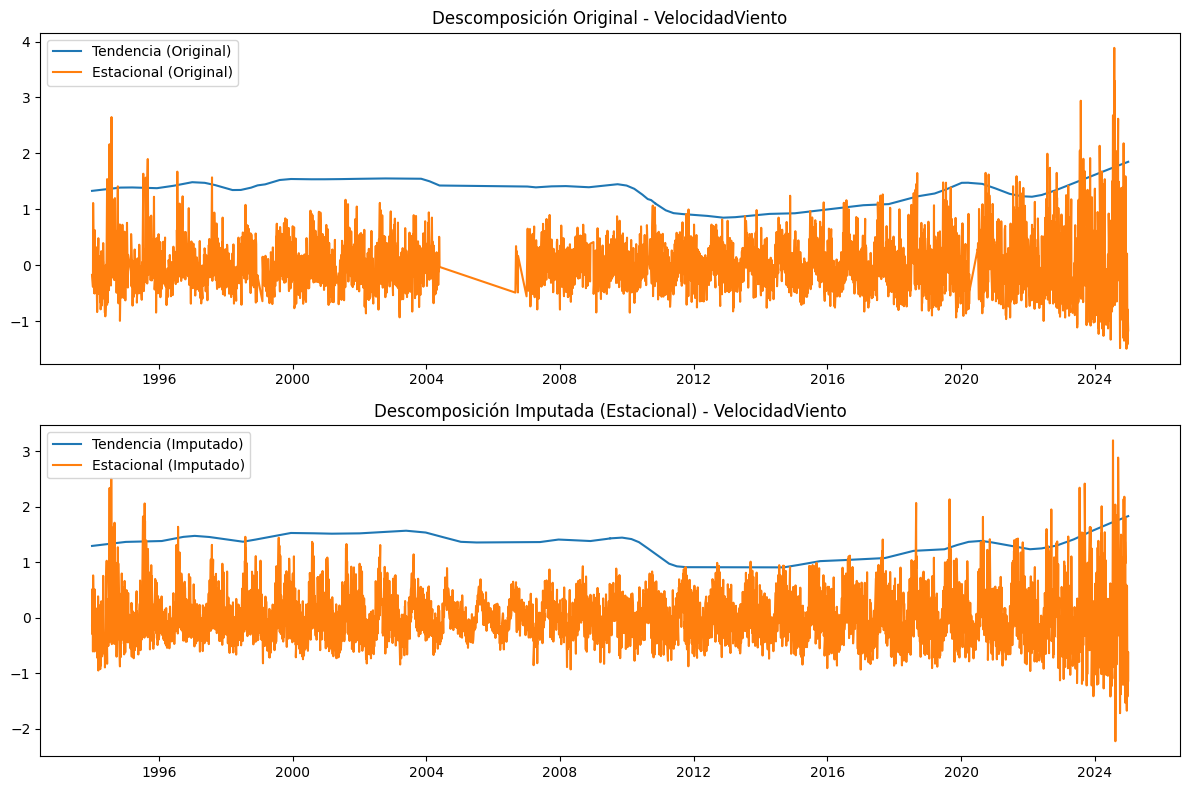


Evaluación de la variable: HorasSol



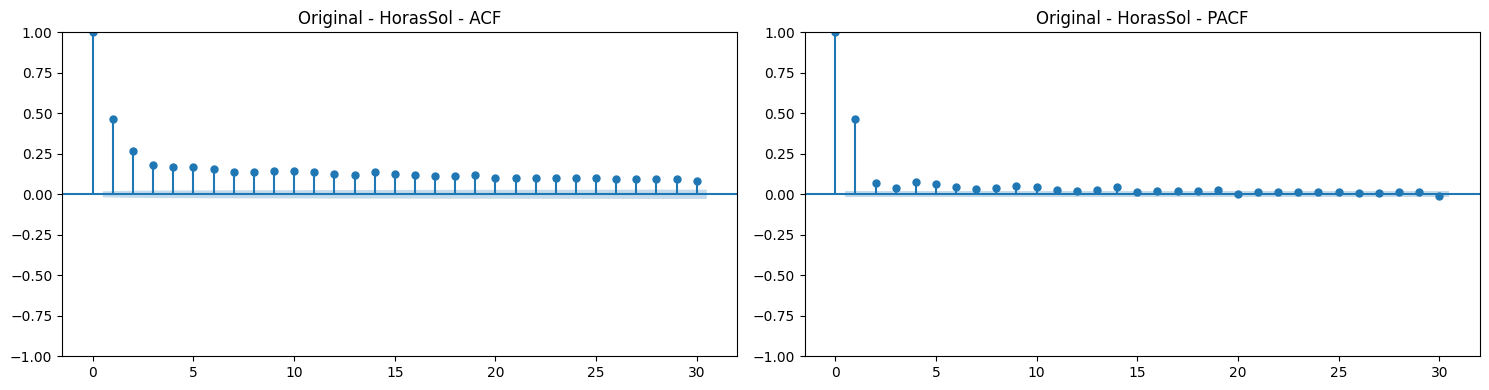

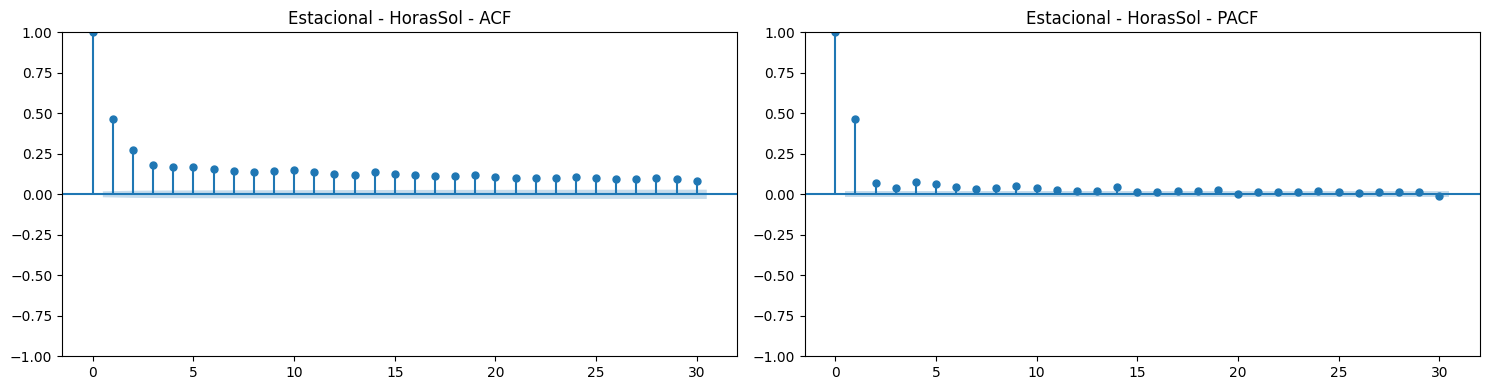

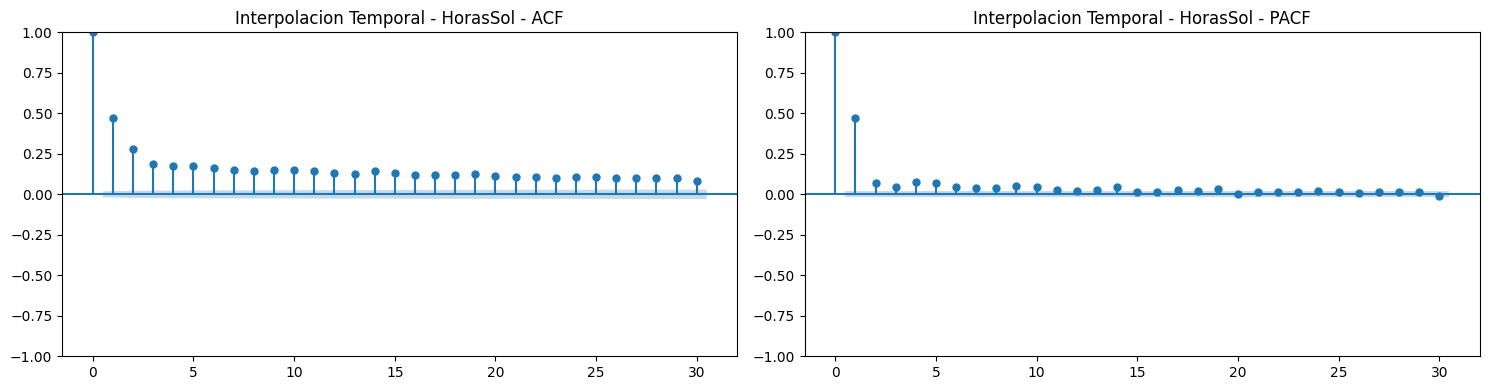

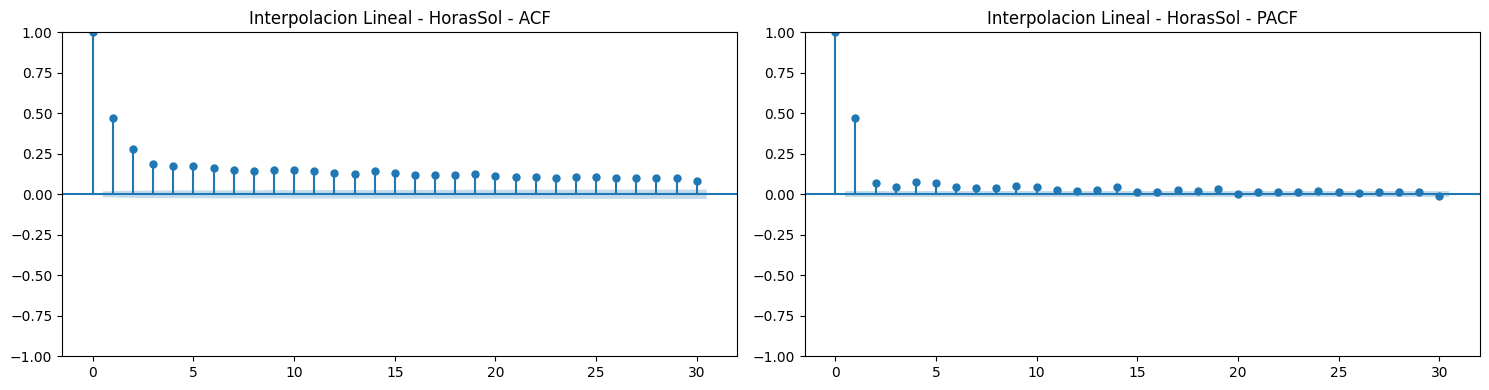

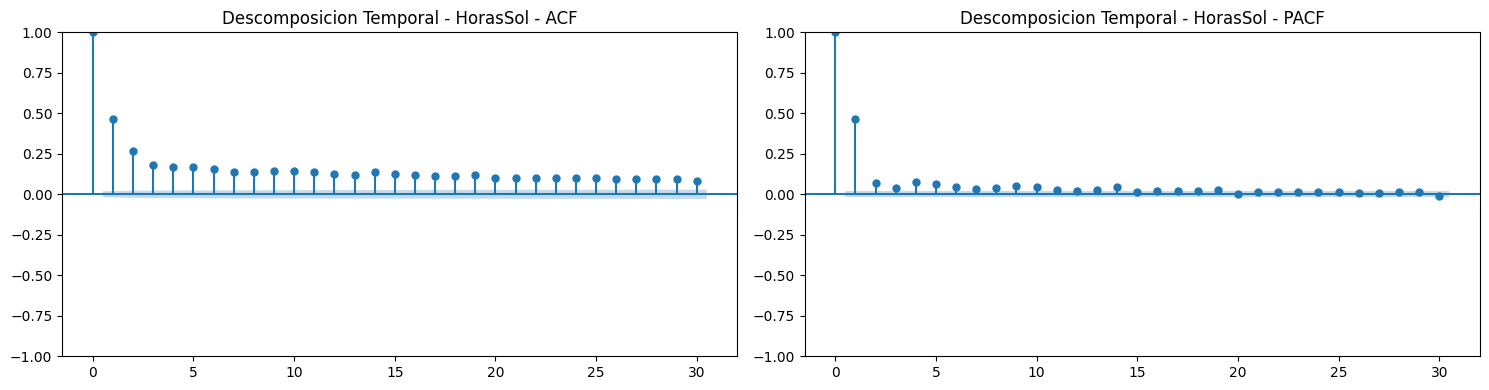

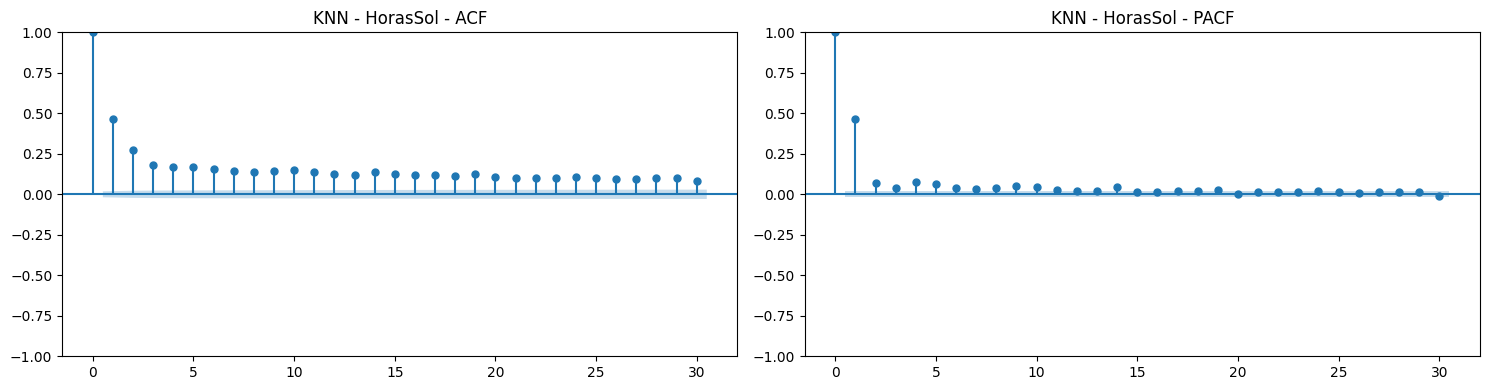

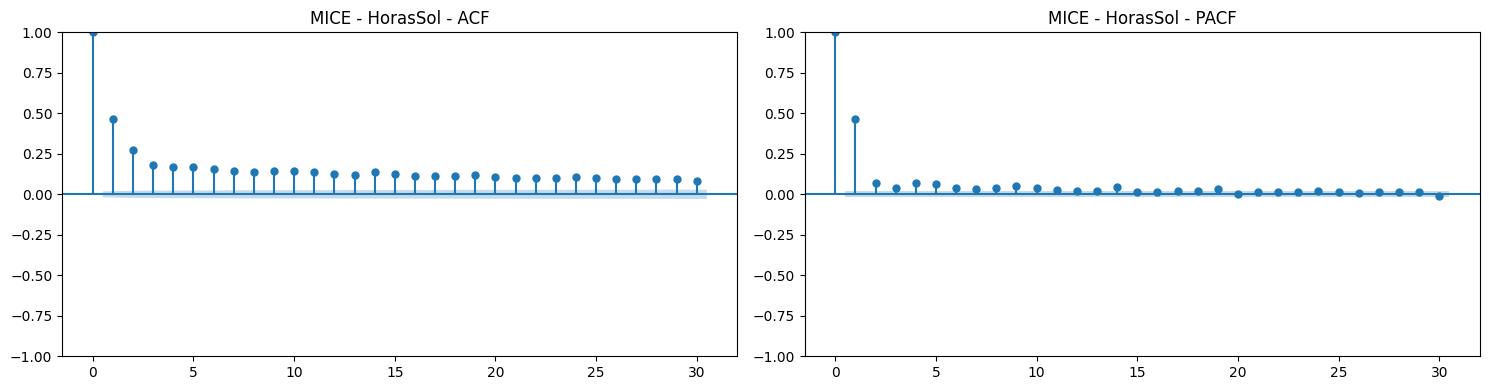

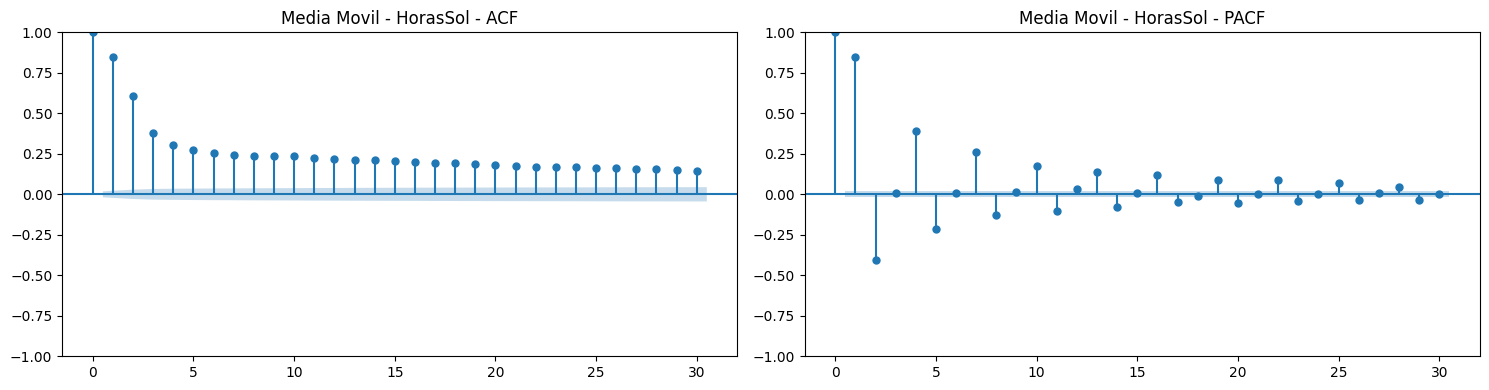

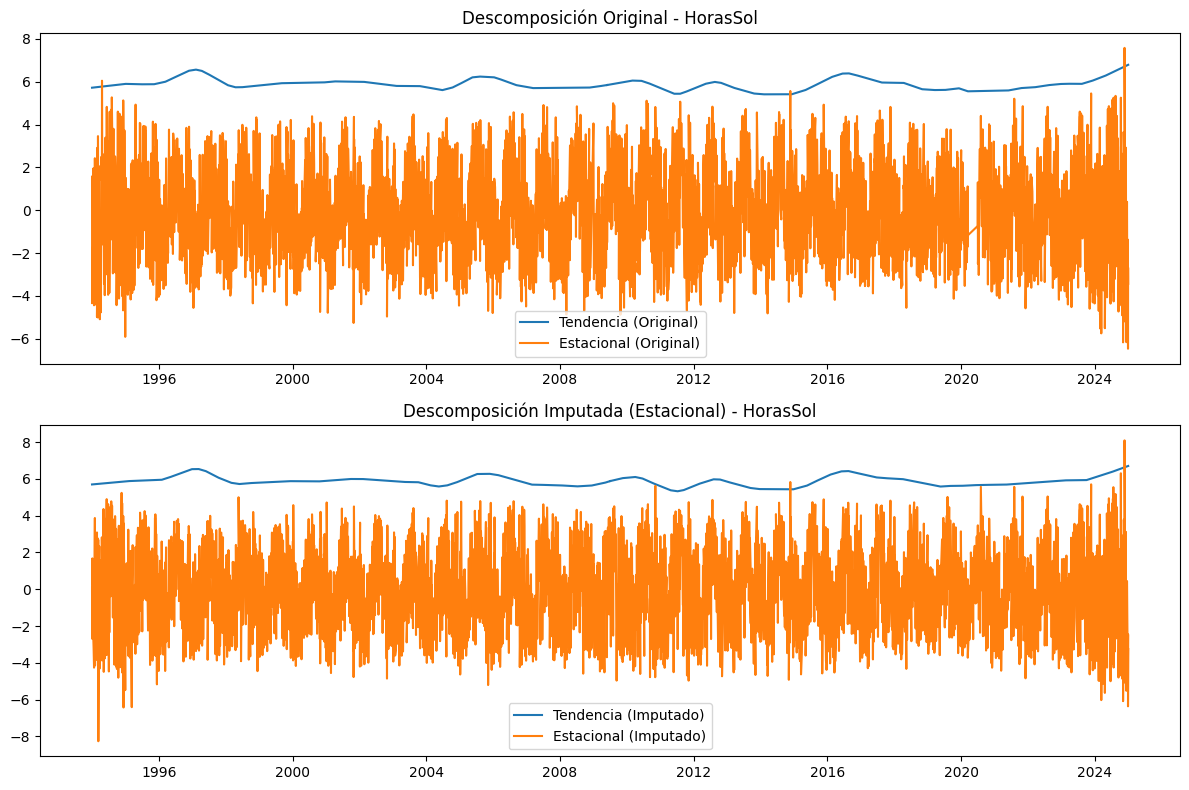

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

# Definir las variables de interés
columnas_a_imputar = ['PrecipitacionDiaria', 'TemperaturaMedia', 'HumedadRelativa',
                        'PresionAtmosferica', 'VelocidadViento', 'HorasSol']

# Crear un diccionario con los dataframes de cada método de imputación
# Incluimos el dataframe original para comparar
imputation_methods = {
    'Original': df_procesado,
    'Estacional': df_imputacion_estacional,
    'Interpolacion Temporal': df_imputacion_interpolacion_temporal,
    'Interpolacion Lineal': df_imputacion_interpolacion_lineal,
    'Descomposicion Temporal': df_imputacion_descomposicion_temporal,
    'KNN': df_imputacion_knn,
    'MICE': df_imputacion_mice,
    'Media Movil': df_imputacion_media_movil
}

# Parámetros para ACF/PACF
lags = 30  # Número de rezagos a evaluar

# Función para graficar ACF y PACF de una serie
def plot_acf_pacf(series, title_prefix):
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    sm.graphics.tsa.plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title(f'{title_prefix} - ACF')
    sm.graphics.tsa.plot_pacf(series, lags=lags, ax=axes[1], method='ywm')
    axes[1].set_title(f'{title_prefix} - PACF')
    plt.tight_layout()
    plt.show()

# Evaluación dinámica para cada variable
for variable in columnas_a_imputar:
    print(f'\nEvaluación de la variable: {variable}\n')

    # Comparar ACF y PACF de cada método
    for method, df_method in imputation_methods.items():
        # Asegurarse de que la serie no tenga valores nulos (si es que aún persisten)
        series = df_method[variable].dropna()
        if series.empty:
            print(f'La serie para {variable} en el método {method} está vacía.')
            continue

        plot_acf_pacf(series, f'{method} - {variable}')

    # Ejemplo de comparación de descomposición temporal:
    # Aquí usamos el método 'Original' y uno de los imputados (por ejemplo, Estacional)
    # Se asume un período estacional; ajústalo según tus datos (por ejemplo, 365 para datos diarios anuales)
    periodo_estacional = 365  # Modificar según corresponda

    try:
        # Descomposición de la serie original
        series_orig = imputation_methods['Original'][variable].dropna()
        stl_orig = STL(series_orig, period=periodo_estacional, robust=True).fit()

        # Descomposición de la serie imputada (ejemplo: imputación estacional)
        series_imp = imputation_methods['Estacional'][variable].dropna()
        stl_imp = STL(series_imp, period=periodo_estacional, robust=True).fit()

        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
        axes[0].plot(series_orig.index, stl_orig.trend, label='Tendencia (Original)')
        axes[0].plot(series_orig.index, stl_orig.seasonal, label='Estacional (Original)')
        axes[0].set_title(f'Descomposición Original - {variable}')
        axes[0].legend()

        axes[1].plot(series_imp.index, stl_imp.trend, label='Tendencia (Imputado)')
        axes[1].plot(series_imp.index, stl_imp.seasonal, label='Estacional (Imputado)')
        axes[1].set_title(f'Descomposición Imputada (Estacional) - {variable}')
        axes[1].legend()

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f'No se pudo realizar la descomposición para {variable}: {e}')


Para elegir el mejor método de imputación, considera los siguientes criterios basados en los resultados obtenidos:

1. Preservación de la Dependencia Temporal (ACF y PACF)
ACF Diff y PACF Diff (Diferencia de ACF y PACF)

Menor valor es mejor: Una menor diferencia indica que el método de imputación mantiene mejor la estructura de correlación temporal.

Interpretación: Si los valores son altos, significa que la imputación ha alterado significativamente la relación entre observaciones a diferentes rezagos, lo que puede afectar la calidad del modelo predictivo.

2. Conservación de Componentes de la Serie Temporal
Tendencia Corr (Correlación de la Tendencia)

Más cercano a 1 es mejor: Indica que la tendencia general de la serie antes y después de la imputación es similar.

Interpretación: Un valor bajo sugiere que el método ha alterado la evolución a largo plazo de la variable.

Estacionalidad Corr (Correlación de la Estacionalidad)

Más cercano a 1 es mejor: Indica que la estructura estacional no se ha visto afectada por la imputación.

Importante para: Variables con ciclos claros, como temperatura o precipitación.

Residuo RMSE (Error Cuadrático Medio del Residuo)

Menor valor es mejor: Indica que las fluctuaciones residuales son similares antes y después de la imputación.

Interpretación: Un valor alto puede indicar que la imputación ha generado ruido adicional o alterado la variabilidad natural de la serie.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import STL

# Función para calcular diferencias en ACF y PACF
def calcular_acf_pacf_diferencia(original, imputado, lags=30):
    original = original.dropna()
    imputado = imputado.dropna()
    min_len = min(len(original), len(imputado))
    original, imputado = original.iloc[:min_len], imputado.iloc[:min_len]

    acf_orig = acf(original, nlags=lags, fft=False)
    acf_imp = acf(imputado, nlags=lags, fft=False)
    pacf_orig = pacf(original, nlags=lags)
    pacf_imp = pacf(imputado, nlags=lags)

    acf_diff = np.mean(np.abs(acf_orig - acf_imp))
    pacf_diff = np.mean(np.abs(pacf_orig - pacf_imp))
    return acf_diff, pacf_diff

# Función para evaluar la preservación de componentes temporales
def calcular_preservacion_componentes(original, imputado, periodo_estacional=365):
    original = original.dropna()
    imputado = imputado.dropna()
    min_len = min(len(original), len(imputado))
    original, imputado = original.iloc[:min_len], imputado.iloc[:min_len]

    stl_orig = STL(original, period=periodo_estacional).fit()
    stl_imp = STL(imputado, period=periodo_estacional).fit()

    tendencia_corr = np.corrcoef(stl_orig.trend, stl_imp.trend)[0, 1]
    estacionalidad_corr = np.corrcoef(stl_orig.seasonal, stl_imp.seasonal)[0, 1]
    residuo_rmse = np.sqrt(np.mean((stl_orig.resid - stl_imp.resid) ** 2))

    return tendencia_corr, estacionalidad_corr, residuo_rmse

# Diccionario con dataframes de imputaciones
df_imputaciones = {
    'Media Móvil': df_imputacion_media_movil,
    'Estacional': df_imputacion_estacional,
    'Interpolación Temporal': df_imputacion_interpolacion_temporal,
    'Interpolación Lineal': df_imputacion_interpolacion_lineal,
    'Descomposición Temporal': df_imputacion_descomposicion_temporal,
    'KNN': df_imputacion_knn,
    'MICE': df_imputacion_mice
}

# Evaluación de cada método por variable ambiental
resultados = []
for metodo, df_imputado in df_imputaciones.items():
    for variable in columnas_a_imputar:
        original = df_procesado[variable]
        imputado = df_imputado[variable]

        acf_diff, pacf_diff = calcular_acf_pacf_diferencia(original, imputado)
        tendencia_corr, estacionalidad_corr, residuo_rmse = calcular_preservacion_componentes(original, imputado)

        score_final = (tendencia_corr + estacionalidad_corr) / (1 + acf_diff + pacf_diff + residuo_rmse)

        resultados.append([metodo, variable, acf_diff, pacf_diff, tendencia_corr, estacionalidad_corr, residuo_rmse, score_final])

# Crear DataFrame con los resultados
df_resultados = pd.DataFrame(resultados, columns=['Método', 'Variable', 'ACF Diff', 'PACF Diff', 'Tendencia Corr', 'Estacionalidad Corr', 'Residuo RMSE', 'Score Final'])

# Ordenar y seleccionar el mejor método por variable
df_mejores = df_resultados.sort_values(by=['Variable', 'Score Final'], ascending=[True, False]).groupby('Variable').first().reset_index()

# Mostrar los mejores métodos por variable
print(df_mejores)

# Guardar resultados a CSV
df_mejores.to_csv('evaluacion_mejores_imputaciones.csv', index=False)


              Variable                   Método      ACF Diff     PACF Diff  \
0             HorasSol  Descomposición Temporal  2.820325e-17  2.229784e-17   
1      HumedadRelativa  Descomposición Temporal  1.432546e-17  1.133026e-16   
2  PrecipitacionDiaria  Descomposición Temporal  3.581365e-18  9.303154e-18   
3   PresionAtmosferica  Descomposición Temporal  1.146037e-16  6.912034e-16   
4     TemperaturaMedia  Descomposición Temporal  2.865092e-17  4.443130e-17   
5      VelocidadViento  Descomposición Temporal  1.128130e-16  6.197440e-17   

   Tendencia Corr  Estacionalidad Corr  Residuo RMSE  Score Final  
0             1.0                  1.0  8.817084e-16          2.0  
1             1.0                  1.0  7.787803e-15          2.0  
2             1.0                  1.0  5.123121e-16          2.0  
3             1.0                  1.0  2.633412e-14          2.0  
4             1.0                  1.0  1.226352e-15          2.0  
5             1.0                  1.0

In [ ]:
# prompt: basandote en el codigo anterior y los resultados, presenta los valores de NRMSE para cada componente y método de imputación por cada variable , generando una tabla que muestre el metodo, la variable, tendencia, estacionalidad y residual

from tabulate import tabulate

# Assuming df_resultados DataFrame from the previous code

# Create a list to store the data for the table
table_data = []

# Iterate through the results and format them for the table
for index, row in df_resultados.iterrows():
    table_data.append([
        row['Método'],
        row['Variable'],
        row['Tendencia Corr'],
        row['Estacionalidad Corr'],
        row['Residuo RMSE']
    ])

# Define the table headers
headers = ["Método", "Variable", "Tendencia", "Estacionalidad", "Residuo"]

# Print the table using tabulate
print(tabulate(table_data, headers=headers, tablefmt="grid"))


## 3. EVALUACION DE LA ESTRUCTURA TEMPORAL Y LA COMPLEJIDAD

* Estadísticos de Reversibilidad Temporal:

  Calcula coeficientes que midan la simetría temporal y compáralos antes y después de la imputación para detectar cambios en la dinámica de la serie.

* Cruces por Cero y Persistencia:

  Analiza la frecuencia de cruces por el nivel medio y la duración de periodos por encima o por debajo de ciertos umbrales, lo que es útil para detectar alteraciones en variables como precipitación o velocidad del viento.

* Análisis de Recurrencia:

  Utiliza gráficos de recurrencia (RP) y análisis de cuantificación de recurrencia (RQA) para evaluar métricas como determinismo, entropía y laminaridad, permitiendo detectar cambios sutiles en la dinámica temporal.

* Métricas de Información:

  Calcula la entropía aproximada (ApEn), la entropía muestral (SampEn) o la información mutua en distintos rezagos. Estas medidas ayudan a identificar alteraciones en la complejidad y predictibilidad de la serie.

In [ ]:
!pip install pyunicorn
!pip install antropy

In [ ]:
import numpy as np
import pandas as pd
from antropy import sample_entropy, app_entropy
from pyunicorn.timeseries import RecurrencePlot
from scipy.stats import entropy

# Funciones para evaluar estructura temporal y complejidad
def calcular_reversibilidad_temporal(serie):
    return np.mean(np.abs(serie.diff().dropna()))

def calcular_cruces_por_cero(serie):
    return np.sum(np.diff(np.sign(serie - serie.mean())) != 0)

def calcular_recurrencia(serie, threshold=0.1):
    serie = serie.dropna().values  # Convertir a array eliminando NaN
    rp = RecurrencePlot(serie, threshold=threshold)
    determinismo = rp.determinism()
    laminaridad = rp.laminarity()
    rec_matrix = rp.recurrence_matrix()
    histograma = np.sum(rec_matrix, axis=1)
    entropia_rqa = entropy(histograma + 1e-10)
    return determinismo, entropia_rqa, laminaridad

def calcular_entropia(serie):
    serie = serie.dropna().values
    return sample_entropy(serie, 2, 0.2 * np.std(serie)), app_entropy(serie, 2, 0.2 * np.std(serie))

# Diccionario con dataframes de imputaciones
df_imputaciones = {
    'Media Móvil': df_imputacion_media_movil,
    'Estacional': df_imputacion_estacional,
    'Interpolación Temporal': df_imputacion_interpolacion_temporal,
    'Interpolación Lineal': df_imputacion_interpolacion_lineal,
    'Descomposición Temporal': df_imputacion_descomposicion_temporal,
    'KNN': df_imputacion_knn,
    'MICE': df_imputacion_mice
}

# Evaluación de cada método por variable ambiental
estructura_resultados = []
for metodo, df_imputado in df_imputaciones.items():
    for variable in columnas_a_imputar:
        imputado = df_imputado[variable]

        reversibilidad = calcular_reversibilidad_temporal(imputado)
        cruces_cero = calcular_cruces_por_cero(imputado)
        recurrencia = calcular_recurrencia(imputado)
        entropia_samp, entropia_aprox = calcular_entropia(imputado)

        score_estructura = (reversibilidad + cruces_cero + recurrencia[0]) / (1 + entropia_samp + entropia_aprox)
        estructura_resultados.append([metodo, variable, reversibilidad, cruces_cero, recurrencia[0], recurrencia[1], recurrencia[2], entropia_samp, entropia_aprox, score_estructura])

# Crear DataFrame con los resultados
df_estructura = pd.DataFrame(estructura_resultados, columns=['Método', 'Variable', 'Reversibilidad', 'Cruces Cero', 'Determinismo', 'Entropía RQA', 'Laminaridad', 'Entropía SampEn', 'Entropía ApEn', 'Score Estructura'])

# Obtener mejores métodos
df_mejores_estructura = df_estructura.sort_values(by=['Variable', 'Score Estructura'], ascending=[True, False]).groupby('Variable').first().reset_index()
print(df_mejores_estructura)

# Guardar resultados
df_mejores_estructura.to_csv('evaluacion_estructura_temporal.csv', index=False)


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


## 4. CONSERVACION DE EVENTOS EXTREMOS
* Eventos Máximos y Mínimos:

  Analiza la distribución de valores extremos (máximos y mínimos) por periodos y verifica que la intensidad y frecuencia de estos eventos se mantengan tras la imputación, aspecto especialmente relevante en variables ambientales.
